In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [3]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Imputed.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold'
]]
Ames_Columns_Ordinal = Ames[[ 
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]]
Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype(str)

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [4]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [5]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

In [6]:
def Plot_Feature_SHAP_Importances(model, model_name, X=X, top_n=20, use_all_rows=True, max_estimators=20):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    #--Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        # Average feature importances over estimators (bagged models)
        if max_estimators < len(best_model.estimators_):
            selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    #Normalize Feature Importances for all models (XGBoost, LightGBM, Catboost not normalized by default)
    if importances is None:
        print(f'{model_name} does not expose feature importances')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        importances_total = importances.sum()
        if importances_total != 0 and not np.isnan(importances_total):
            importances = importances / importances_total
        else:
            print(f'{model_name} feature importances could not be normalized')
        feature_importance_df = (
            pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)}).sort_values('Importance', ascending=False)
            .reset_index(drop=True)
        )
        
    #--SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0],
                                                  n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)

    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge Feature Importances and SHAP Values
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importance
    feature_shap_df_top = feature_shap_df.head(top_n)
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Feature Importance')
    ax1.set_title(f'{model_name} - Feature Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('SHAP value', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [15]:
def Plot_SHAP_Values_only(model, model_name, X=X, top_n=10, use_all_rows=True, max_estimators=20):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model

    #--Feature Importances
    importances = None
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        # Average feature importances over estimators (bagged models)
        if max_estimators < len(best_model.estimators_):
            selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
        else:
            selected_estimators = best_model.estimators_
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif model_name.lower().startswith('cat') and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()
    #Normalize Feature Importances for all models (XGBoost, LightGBM, Catboost not normalized by default)
    if importances is None:
        print(f'{model_name} does not expose feature importances')
        feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        importances_total = importances.sum()
        if importances_total != 0 and not np.isnan(importances_total):
            importances = importances / importances_total
        else:
            print(f'{model_name} feature importances could not be normalized')
        feature_importance_df = (
            pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)}).sort_values('Importance', ascending=False)
            .reset_index(drop=True)
        )
        
    #--SHAP Values
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    try:
        if hasattr(best_model, 'estimators_'):
            if max_estimators < len(best_model.estimators_):
                selected_estimators = random.sample(best_model.estimators_, k=max_estimators)
                temp_model = best_model.__class__(base_estimator=best_model.estimators_[0],
                                                  n_estimators=max_estimators)
                temp_model.estimators_ = selected_estimators
                explainer = shap.TreeExplainer(temp_model)
            else:
                explainer = shap.TreeExplainer(best_model)
        elif hasattr(best_model, 'tree_') or 'Tree' in str(type(best_model)):
            explainer = shap.TreeExplainer(best_model)
        else:
            explainer = shap.Explainer(best_model, X_sample)
        shap_values = explainer(X_sample)
    except Exception:
        explainer = shap.Explainer(best_model.predict, X_sample)
        shap_values = explainer(X_sample)

    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)
    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge Feature Importances and SHAP Values
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importance
    #feature_shap_df_top = feature_shap_df.head(top_n)
    #y_pos = np.arange(len(feature_shap_df_top))
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    #ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    #ax1.set_yticks(y_pos)
    #ax1.set_yticklabels(feature_shap_df_top['Feature'])
    #ax1.invert_yaxis()
    #ax1.set_xlabel('Feature Importance')
    #ax1.set_title(f'{model_name} - Top {top_n} Feature Importances')
    #ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    #ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    #ax2.set_xlabel('|SHAP value| (Avg Impact)')
    #ax2.set_title(f'{model_name} - SHAP Values')
    #ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    #plt.tight_layout()
    #plt.show()

    #Sort features by absolute SHAP value and take top_n
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    #Single SHAP bar plot
    fig, ax = plt.subplots(figsize=(10, top_n * 0.5), dpi=600)
    ax.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax.set_yticks(y_pos_shap)
    ax.set_yticklabels(shap_feature_df_top['Feature'])
    ax.set_xlabel('|SHAP value| (Avg Impact)')
    ax.set_title(f'{model_name} - Top {top_n} SHAP Feature Values')
    ax.invert_yaxis()  # Highest SHAP value on top
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('SHAP value', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display
    display(feature_shap_df.head(top_n).style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))

In [8]:
def Plot_HGB_Feature_SHAP_Importances(model, X=X, Y=Y, top_n=20, use_all_rows=True, n_permutations=10):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__

    #Permutation Feature Importances
    print(f'Calculating permutation importances for {model_name}...')
    perm_imp = permutation_importance(best_model, X, Y, n_repeats=n_permutations, random_state=2, n_jobs=-1)
    feature_importance_df = (
        pd.DataFrame({'Feature': X.columns, 'Importance': perm_imp.importances_mean})
        .sort_values('Importance', ascending=False)
    )

    #SHAP Values
    print(f'Calculating SHAP values for {model_name}...')
    X_sample = X.copy() if use_all_rows else X.sample(min(500, X.shape[0]), random_state=2)
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer(X_sample)
    shap_vals = shap_values.values if hasattr(shap_values, 'values') else shap_values
    shap_abs_mean = np.abs(shap_vals).mean(axis=0)

    shap_value_df = (
        pd.DataFrame({'Feature': X_sample.columns, '|SHAP value|': shap_abs_mean})
        .sort_values('|SHAP value|', ascending=False)
    )

    #Merge
    feature_shap_df = pd.merge(feature_importance_df, shap_value_df, on='Feature', how='outer')
    feature_shap_df = feature_shap_df.sort_values('Importance', ascending=False)

    #Side by Side Plots: Sorted by Feature Importances
    feature_shap_df_top = feature_shap_df.head(top_n).copy()
    y_pos = np.arange(len(feature_shap_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos, feature_shap_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(feature_shap_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Top {top_n} Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos, feature_shap_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Side by Side Plots: Sorted by SHAP Value
    shap_feature_df_top = feature_shap_df.sort_values('|SHAP value|', ascending=False).head(top_n)
    y_pos_shap = np.arange(len(shap_feature_df_top))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, top_n * 0.5), sharey=True, dpi=600)
    ax1.barh(y_pos_shap, shap_feature_df_top['Importance'], color='teal')
    ax1.set_yticks(y_pos_shap)
    ax1.set_yticklabels(shap_feature_df_top['Feature'])
    ax1.invert_yaxis()
    ax1.set_xlabel('Permutation Importance')
    ax1.set_title(f'{model_name} - Permutation Importances')
    ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    ax2.barh(y_pos_shap, shap_feature_df_top['|SHAP value|'], color='blue')
    ax2.set_xlabel('|SHAP value| (Avg Impact)')
    ax2.set_title(f'{model_name} - Top {top_n} SHAP Values')
    ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))
    plt.tight_layout()
    plt.show()

    #Beeswarm Plot
    print(f'\nSHAP Beeswarm Plot for {model_name}...')
    plt.figure(figsize=(100, max(6, top_n * 0.3)))
    shap.summary_plot(shap_values, X_sample, show=False, max_display=top_n)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:,.0f}'))
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.tick_params(axis='x', labelsize=11, rotation=0)
    xmin, xmax = ax.get_xlim()
    ax.set_xlim(xmin, xmax * 1.05)
    ax.set_xlabel('SHAP value', fontsize=13, labelpad=10)
    ax.set_title(f'{model_name} — SHAP Beeswarm Plot (Top {top_n} Features)', fontsize=14, pad=10)
    plt.tight_layout()
    plt.show()

    #Display + Save
    display(feature_shap_df_top.style.format({'Importance': '{:.4f}', '|SHAP value|': '{:,.0f}'}))
    feature_shap_df.to_csv('HGBM_Feature_Importances_SHAP_Values.csv', index=False)

In [11]:
#Decision Tree Regressor: Base Model
tree_model = DecisionTreeRegressor(random_state=2)
cv_scores = cross_val_score(tree_model, X, Y, cv=5, scoring='r2')

tree_model.fit(X, Y)
tree_mean_cv_score = np.mean(cv_scores)

print(f'Decision Tree Base Model Score: {tree_mean_cv_score:.4f}')

#Results Dataframe
tree_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['DecisionTree'],
    'Mean_R²': [tree_mean_cv_score],
    **{f'Fold_{i+1}_R²': [cv_scores[i]] for i in range(5)}
})

Decision Tree Base Model Score: 0.7798


In [28]:
#Decision Tree Regressor: GridSearchCV
tree_model = DecisionTreeRegressor(random_state=2)

#Grid Search
grid_para_tree = {
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': range(1, 31)
}
grid_search_tree = GridSearchCV(
    estimator=tree_model,
    param_grid=grid_para_tree,
    cv=5,
    scoring='r2',
    n_jobs=-1
)
grid_search_tree.fit(X, Y)

print('Best parameters:', grid_search_tree.best_params_)
print('Best CV accuracy: %.4f' % grid_search_tree.best_score_)

#Results Dataframe
tree_cv_results_df = pd.DataFrame(grid_search_tree.cv_results_)
tree_best_params = grid_search_tree.best_params_
tree_best_score = grid_search_tree.best_score_
tree_best_row = tree_cv_results_df.loc[
    (tree_cv_results_df['param_criterion'] == tree_best_params['criterion']) &
    (tree_cv_results_df['param_max_depth'] == tree_best_params['max_depth'])
]
tree_fold_scores = [tree_best_row[f'split{i}_test_score'].values[0] for i in range(5)]

tree_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['DecisionTree'],
    'Mean_R²': [tree_best_score],
    **{f'Fold_{i+1}_R²': [tree_fold_scores[i]] for i in range(5)}
})

Best parameters: {'criterion': 'squared_error', 'max_depth': 9}
Best CV accuracy: 0.7916


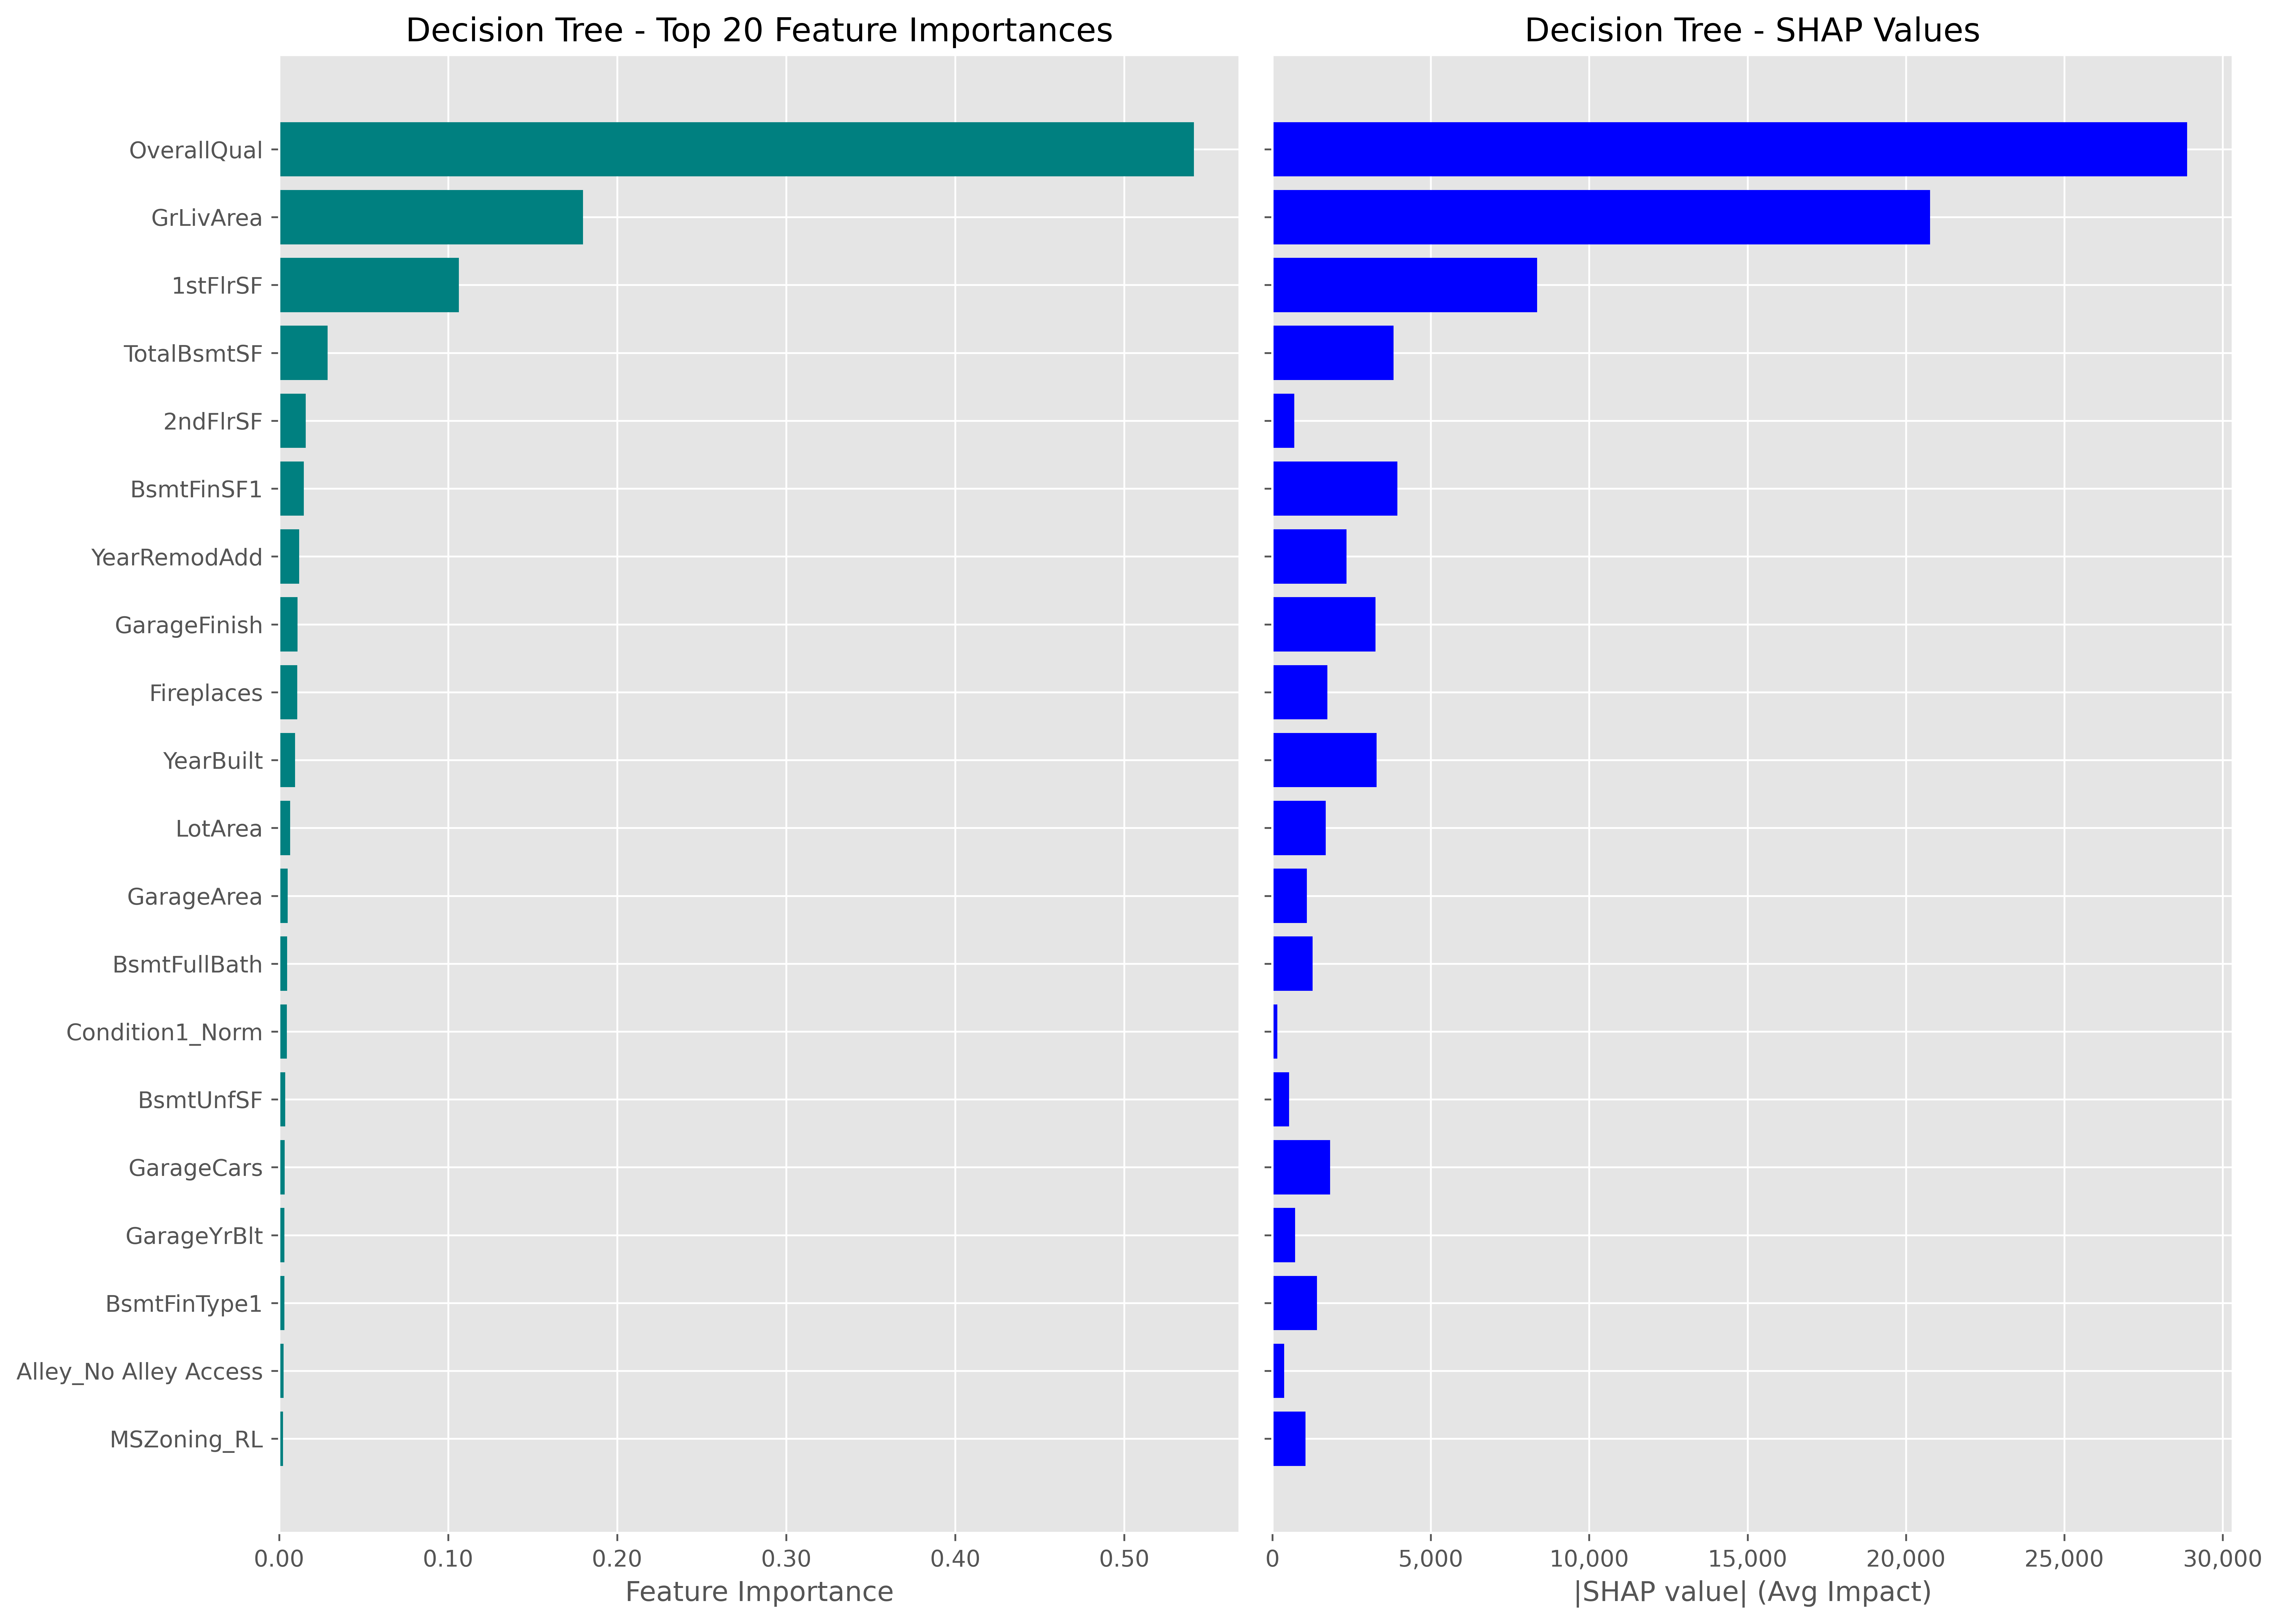

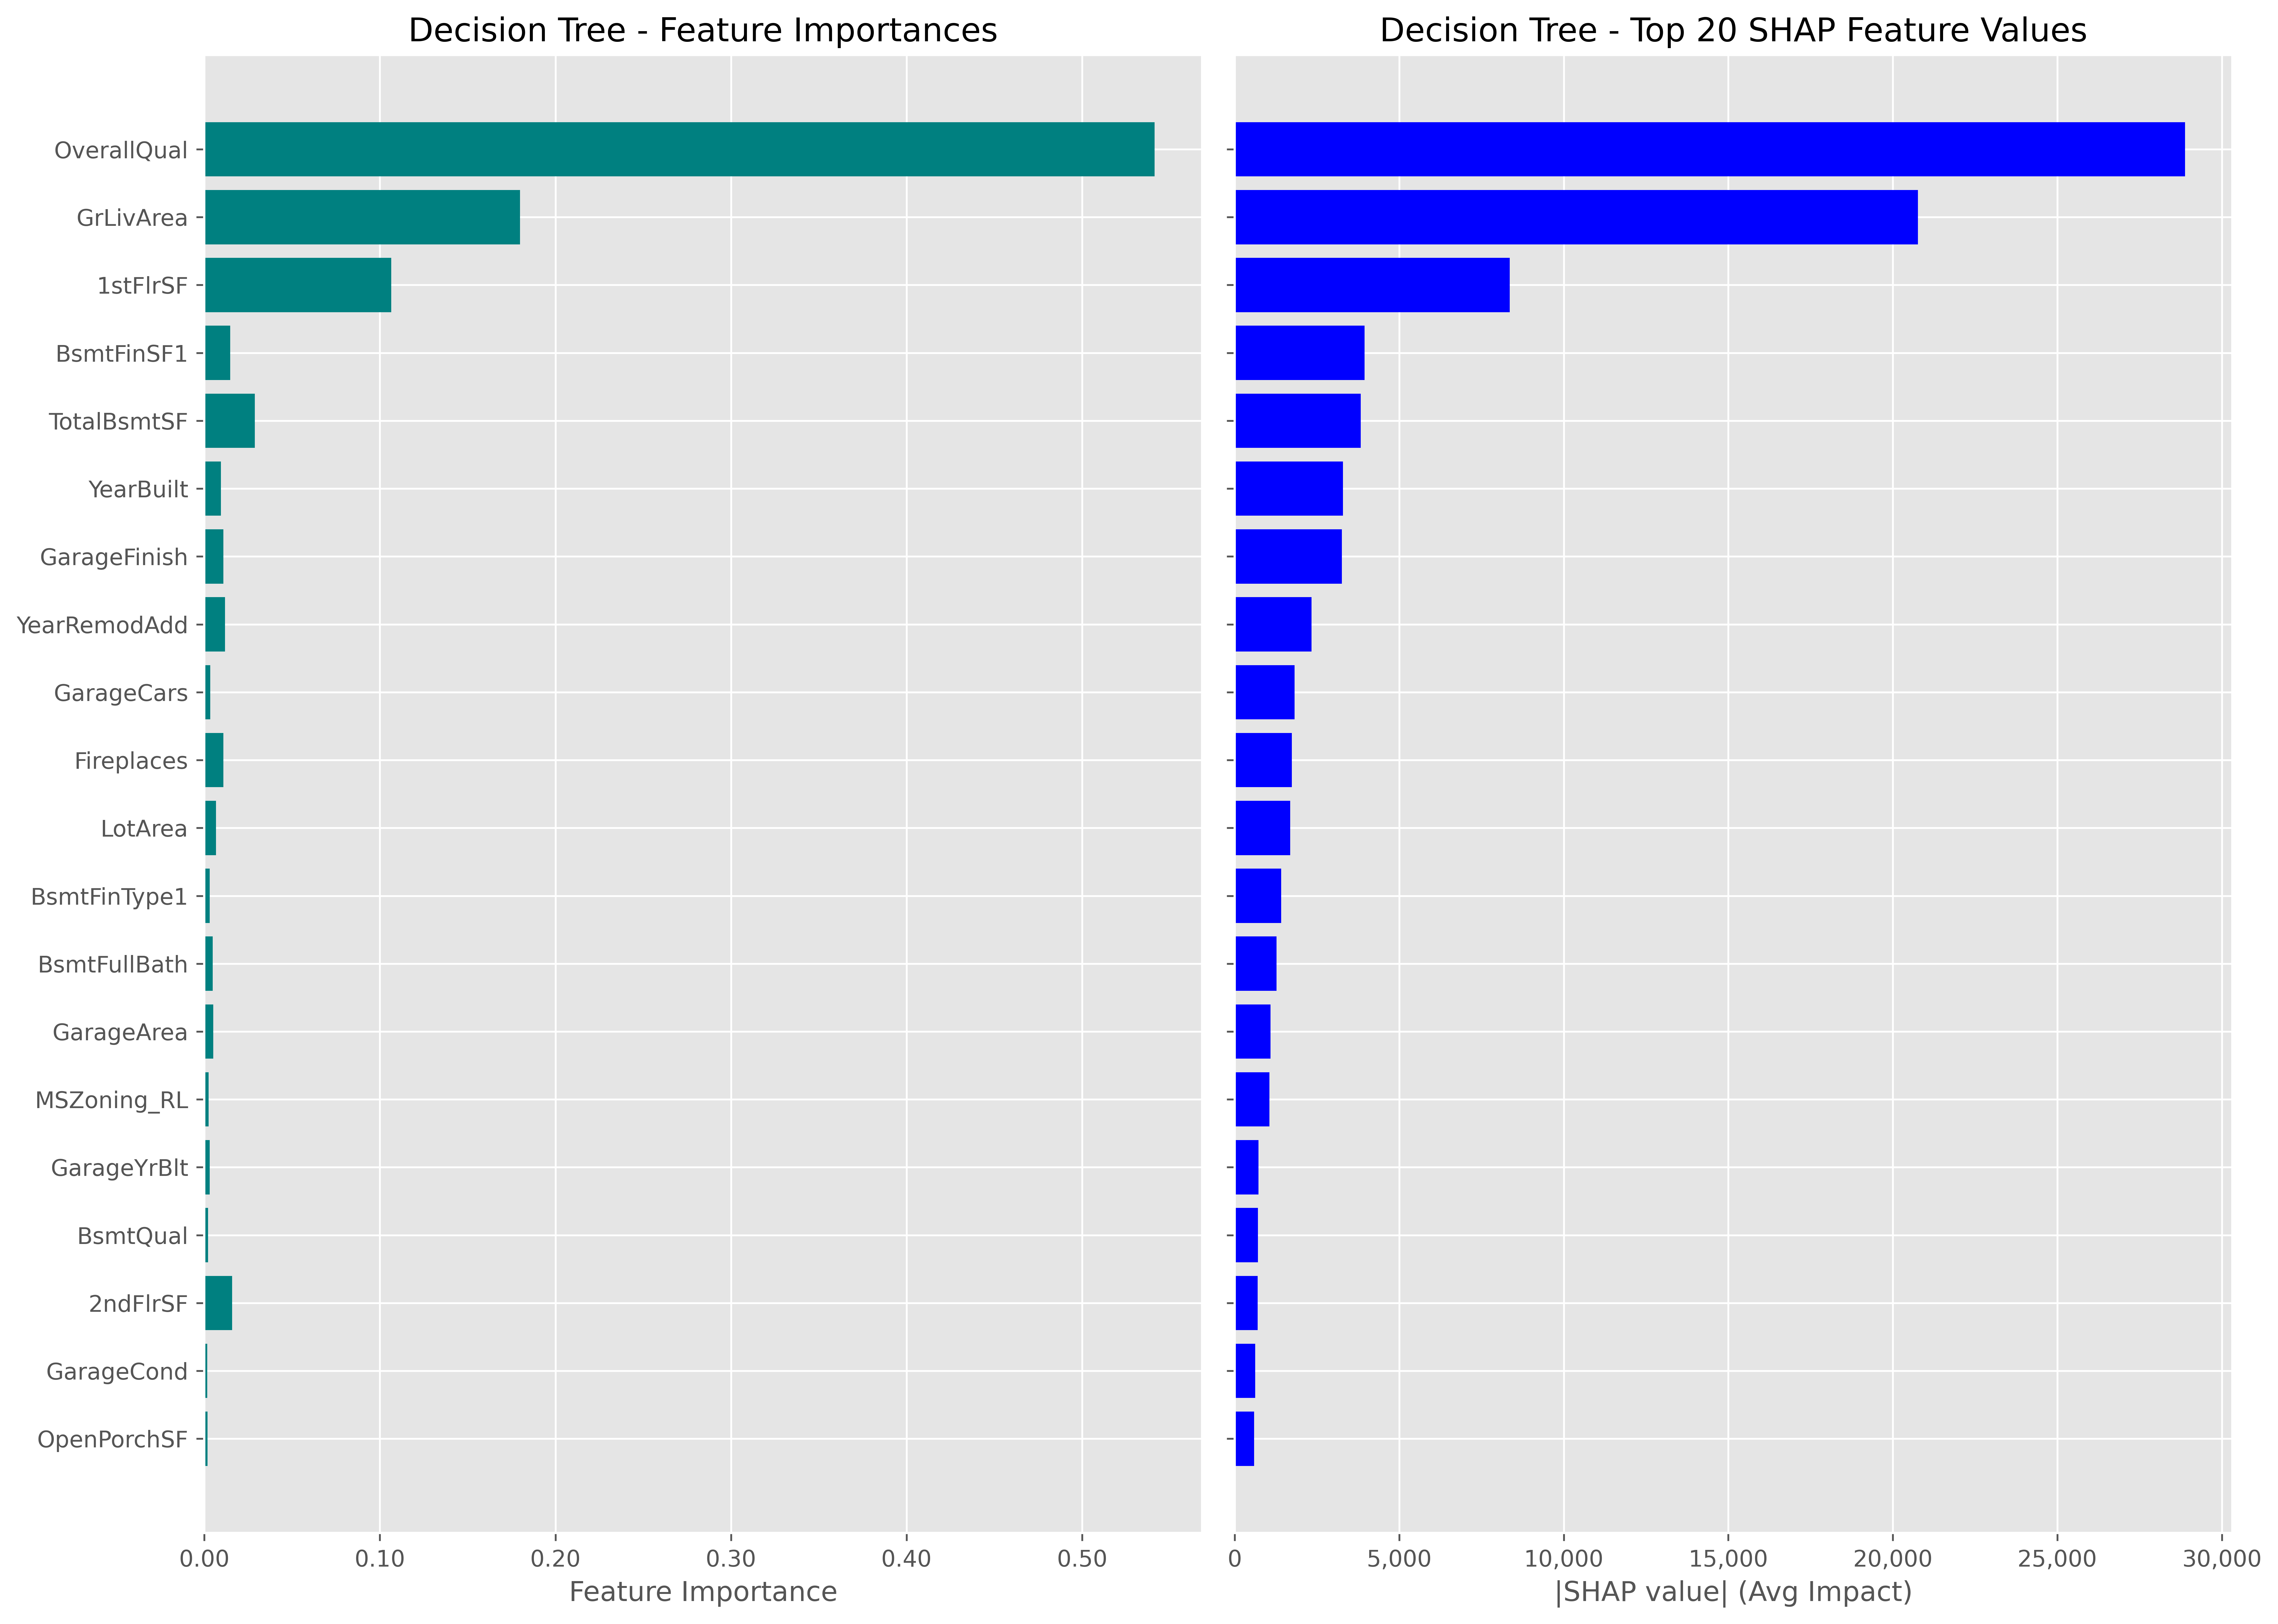


SHAP Beeswarm Plot for Decision Tree...


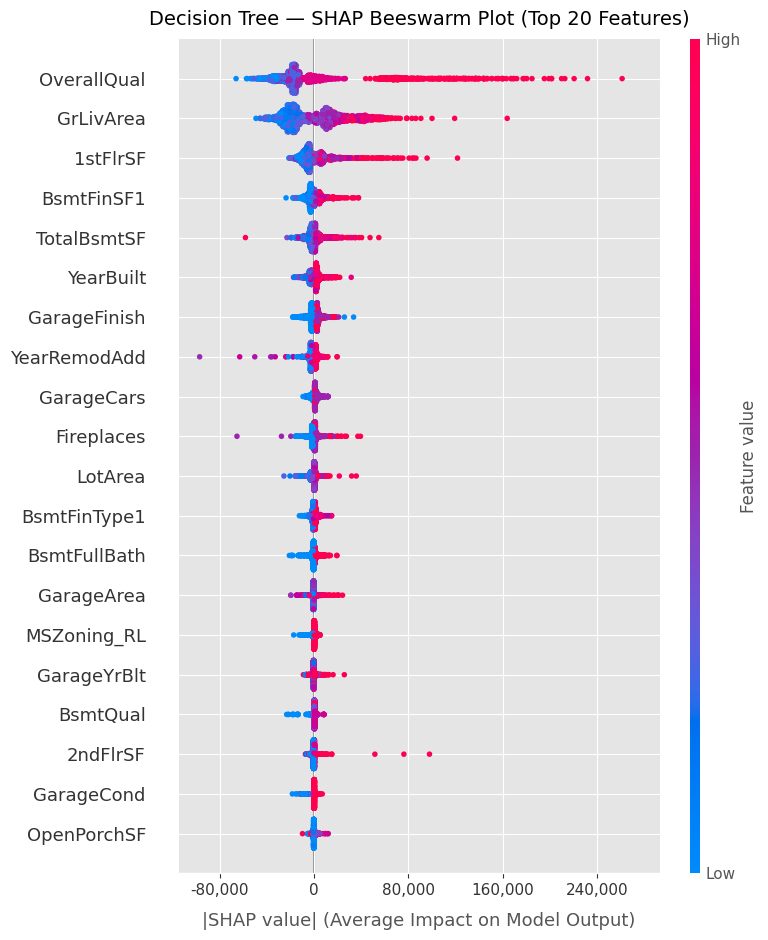

In [15]:
#Decision Tree Regressor Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(grid_search_tree, 'Decision Tree')

In [29]:
#Bagging: Base Model
bag_model = BaggingRegressor(random_state=2)
bag_basic = cross_val_score(bag_model, X, Y, cv=5, scoring='r2')

bag_model.fit(X, Y)
bagging_base_mean_cv_score = np.mean(bag_basic)

print(f'Bagging Base Model Score: {bagging_base_mean_cv_score}')

#Results Dataframe
bag_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['Bagging'],
    'Mean_R²': [bagging_base_mean_cv_score],
    **{f'Fold_{i+1}_R²': [bag_basic[i]] for i in range(5)}
})

Bagging Base Model Score: 0.881530875341394


In [26]:
base_tree = DecisionTreeRegressor(random_state=2)
bagging_model = BaggingRegressor(estimator=base_tree, random_state=2, n_jobs=-1)

In [35]:
#Initial Bagging RandomizedSearchCV for faster estimates
bagging_param = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [75, 76, 77]
}
random_search_bag = RandomizedSearchCV(
    bagging_model,
    param_distributions=bagging_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_bag.fit(X, Y)
print('Best parameters:', random_search_bag.best_params_)
print(f'Best CV Score: {random_search_bag.best_score_:.4f}')

#Results DataFrame
bag_cv_results_df = pd.DataFrame(random_search_bag.cv_results_)
best_row = bag_cv_results_df.loc[bag_cv_results_df['rank_test_score'] == 1].iloc[0]
bag_fold_scores = [best_row[f'split{i}_test_score'] for i in range(5)]

bag_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['Bagging'],
    'Mean_R²': [best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [bag_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'n_estimators': 76, 'estimator__max_depth': 22, 'estimator__criterion': 'squared_error'}
Best CV Score: 0.8960


In [32]:
bag_tuned_results_df

Model_Category Model_Scaling Tuning    Model  Mean_R²  Fold_1_R²  Fold_2_R²  \
0     Tree_Based          None  Tuned  Bagging   0.8960     0.8419     0.8995   

   Fold_3_R²  Fold_4_R²  Fold_5_R²  \
0     0.9089     0.9132     0.9163   

                                         Best_Params  
0  {'n_estimators': 76, 'estimator__max_depth': 2...

In [69]:
#Final Bagging Grid Search
grid_params_bagging = {
    'estimator__criterion': ['squared_error'],
    'estimator__max_depth': [21, 22, 23],
    'n_estimators': [70, 71, 72]
}
grid_search_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=grid_params_bagging,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_bagging.fit(X, Y)

print('Best parameters:', grid_search_bagging.best_params_)
print(f'Best CV Score: {grid_search_bagging.best_score_:.4f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 22, 'n_estimators': 71}
Best CV Score: 0.8959


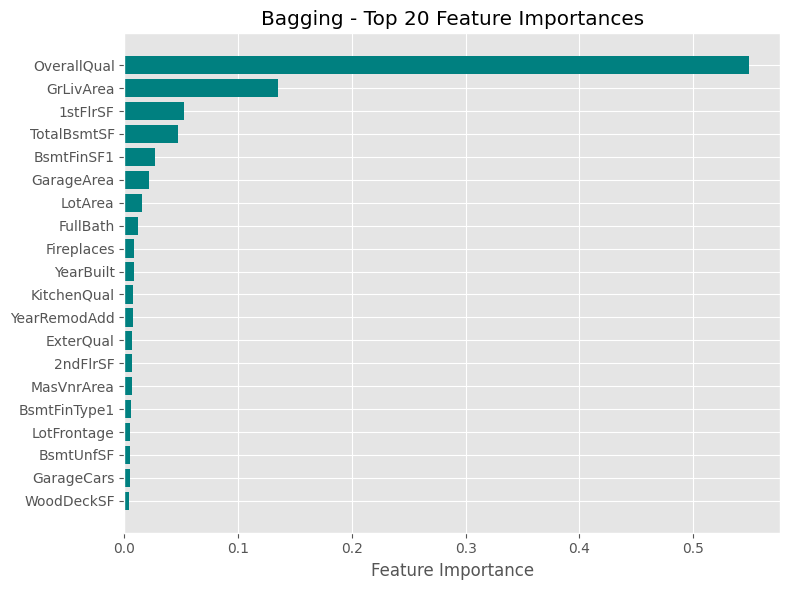

PermutationExplainer explainer: 2580it [26:28,  1.62it/s]                                                              


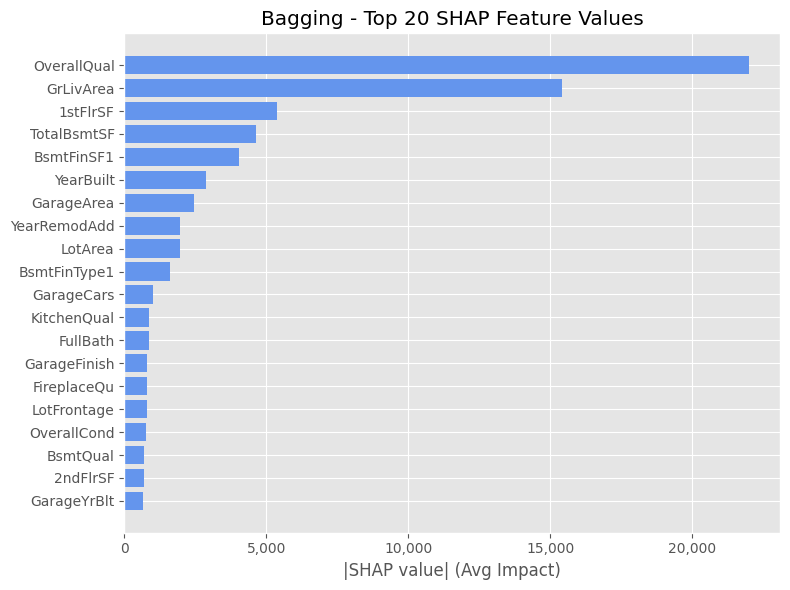

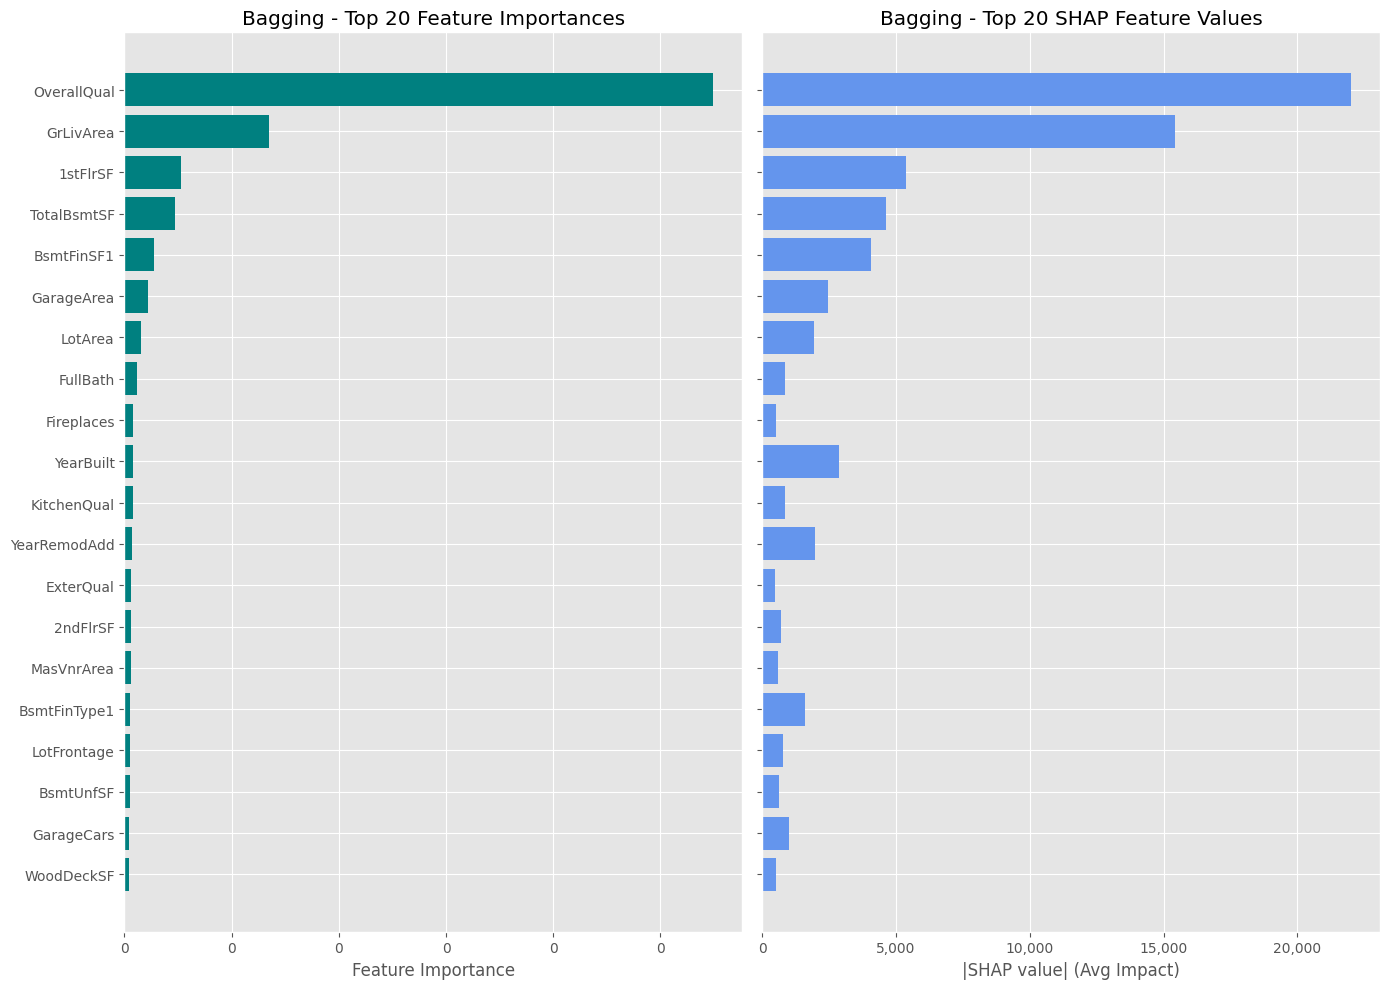

In [91]:
#Bagging Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_bag, 'Bagging')

In [34]:
#Base Random Forest Model 
rf_model = RandomForestRegressor(random_state=2, n_jobs=-1)
rf_cv_scores = cross_val_score(rf_model, X, Y, cv=5, scoring='r2')
rf_model.fit(X, Y)
rf_mean_cv_score = np.mean(rf_cv_scores)
print(f'Random Forest Base Model Mean CV R²: {rf_mean_cv_score}')

#Results Dataframe
rf_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['RandomForest'],
    'Mean_R²': [rf_mean_cv_score],
    **{f'Fold_{i+1}_R²': [rf_cv_scores[i]] for i in range(5)}
})

Random Forest Base Model Mean CV R²: 0.8951755258558339


In [15]:
print('Random Forest Base Model Score:', float(cross_val_score(rf_model, X, Y).mean()))

0.8951755258558339

In [36]:
#Initial Random Forest RandomizedSearchCV for faster estimates
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 27),
    'n_estimators': range(156, 224),
    'max_features': ['sqrt']
}
random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_rf.fit(X, Y)
print('Best parameters:', random_search_rf.best_params_)
print(f'Best CV Score: {random_search_rf.best_score_:.4f}')

#Results Dataframe
rf_cv_results_df = pd.DataFrame(random_search_rf.cv_results_)
rf_best_row = rf_cv_results_df.loc[rf_cv_results_df['rank_test_score'] == 1].iloc[0]
rf_fold_scores = [rf_best_row[f'split{i}_test_score'] for i in range(5)]

rf_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['RandomForest'],
    'Mean_R²': [rf_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [rf_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 213, 'max_features': 'sqrt', 'max_depth': 24, 'criterion': 'friedman_mse'}
Best CV Score: 0.8962


In [29]:
#Final Random Forest Grid Search
rf_param = {
    'criterion': ['friedman_mse'],
    'max_depth': range(21, 28),
    'n_estimators': range(180, 205),
    'max_features': ['sqrt']
}
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X, Y)
print('Best parameters:', grid_search_rf.best_params_)
print(f'Best CV Score: {grid_search_rf.best_score_:.4f}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'criterion': 'friedman_mse', 'max_depth': 24, 'max_features': 'sqrt', 'n_estimators': 192}
Best CV Score: 0.8966


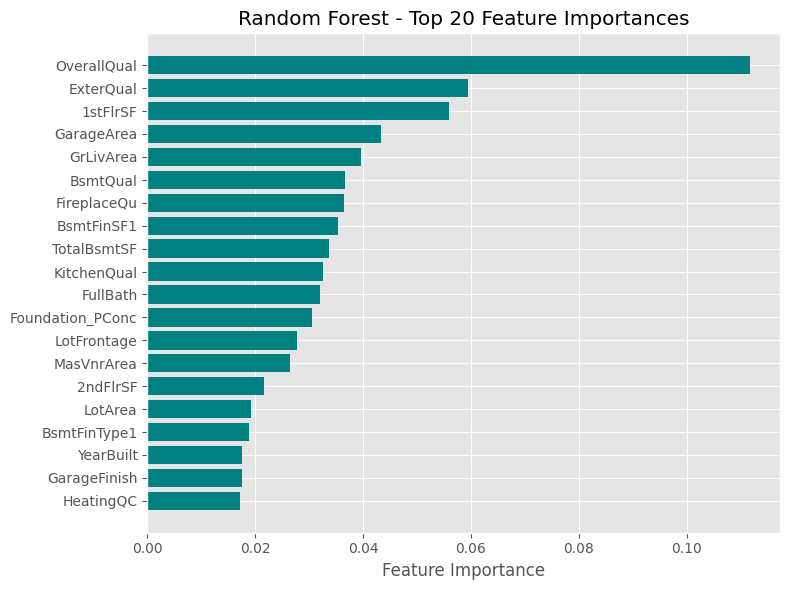

PermutationExplainer explainer: 2580it [06:05,  6.86it/s]                                                              


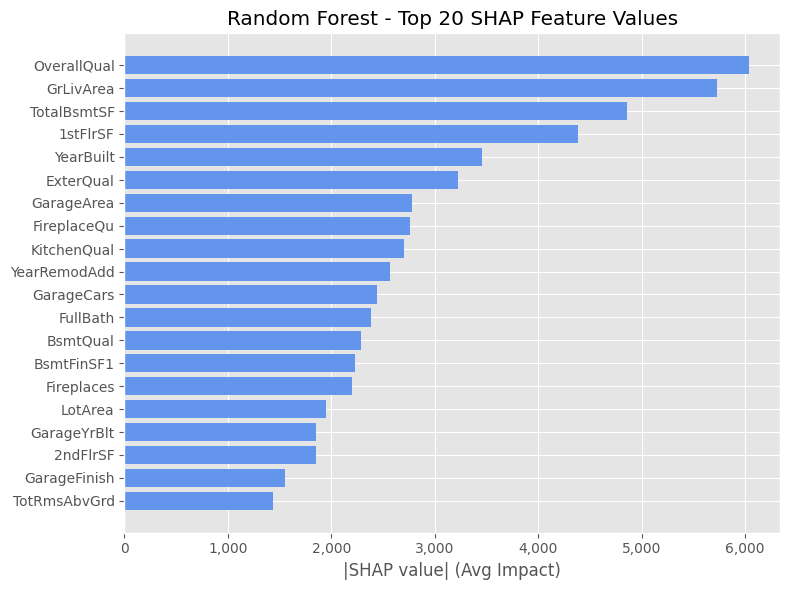

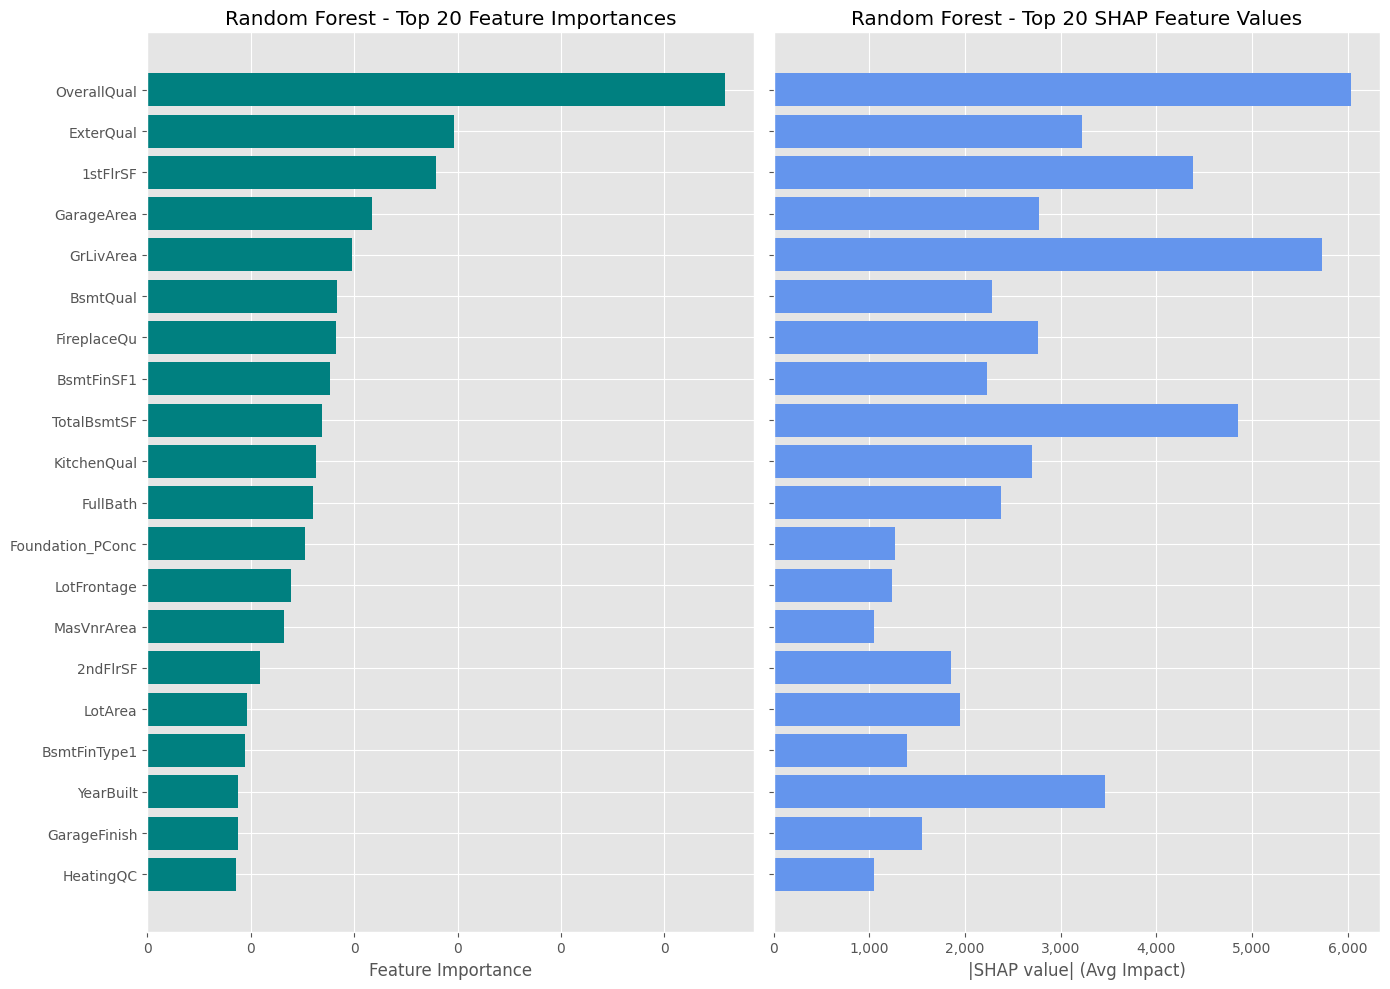

In [95]:
#Random Forest Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_rf, 'Random Forest')

In [38]:
#Gradient Boosting
gbm = GradientBoostingRegressor(random_state=2, verbose=1)
gbm_cv_scores = cross_val_score(gbm, X, Y, cv=5, scoring='r2')
gbm.fit(X, Y)
gbm_mean_cv_score = np.mean(gbm_cv_scores)

print(f'Gradient Boosting Base Model Mean CV R²: {gbm_mean_cv_score}')

#Results Dataframe
gbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['GradientBoosting'],
    'Mean_R²': [gbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [gbm_cv_scores[i]] for i in range(5)}
})

      Iter       Train Loss   Remaining Time 
         1  4541205303.3751            1.06s
         2  3925329347.9286            1.01s
         3  3407690380.5198            0.95s
         4  2973081126.3941            0.91s
         5  2605556518.4339            0.89s
         6  2303283596.7830            0.87s
         7  2044582357.1434            0.85s
         8  1813887944.0161            0.83s
         9  1612351749.8694            0.82s
        10  1453410013.0922            0.80s
        20   612024530.5015            0.71s
        30   374431730.8410            0.63s
        40   285678745.0720            0.53s
        50   242743961.9985            0.45s
        60   214289684.4926            0.37s
        70   195273222.5784            0.28s
        80   180626758.4808            0.19s
        90   168606209.2128            0.09s
       100   157237445.1394            0.00s
      Iter       Train Loss   Remaining Time 
         1  4572328385.6264            0.87s
        

In [32]:
print('GradientBoosting Base Model Score:', float(cross_val_score(gbm, X, Y).mean()))

      Iter       Train Loss   Remaining Time 
         1  4541205303.3751            2.31s
         2  3925329347.9286            2.77s
         3  3407690380.5198            2.48s
         4  2973081126.3941            2.33s
         5  2605556518.4339            2.23s
         6  2303283596.7830            2.13s
         7  2044582357.1434            2.06s
         8  1813887944.0161            2.02s
         9  1612351749.8694            1.99s
        10  1453410013.0922            1.91s
        20   612024530.5015            1.60s
        30   374431730.8410            1.27s
        40   285678745.0720            1.11s
        50   242743961.9985            0.94s
        60   214289684.4926            0.74s
        70   195273222.5784            0.56s
        80   180626758.4808            0.37s
        90   168606209.2128            0.18s
       100   157237445.1394            0.00s
      Iter       Train Loss   Remaining Time 
         1  4572328385.6264            1.35s
        

In [39]:
#Initial Gradient Boosting RandomizedSearchCV for faster estimates
gbm_param = {
    'learning_rate': [.03, .04],
    'subsample': [.1, .2, .3, .4],
    'max_depth': range(25, 29),
    'n_estimators': range(170, 195),
    'criterion': ['friedman_mse'],
    'max_features': ['sqrt']
}
random_search_gbm = RandomizedSearchCV(
    estimator=gbm,
    param_distributions=gbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_gbm.fit(X, Y)
print('Best parameters:', random_search_gbm.best_params_)
print(f'Best CV Score: {random_search_gbm.best_score_:.4f}')

#Results Dataframe
gbm_cv_results_df = pd.DataFrame(random_search_gbm.cv_results_)
gbm_best_row = gbm_cv_results_df.loc[gbm_cv_results_df['rank_test_score'] == 1].iloc[0]
gbm_fold_scores = [gbm_best_row[f'split{i}_test_score'] for i in range(5)]
gbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['GradientBoosting'],
    'Mean_R²': [gbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [gbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1  6213813867.7452   249147279.4664            0.50s
         2  5471706076.0295    61675500.2889            0.46s
         3  4496342502.3873   -67811377.8065            0.44s
         4  4236804137.9424   226051780.4269            0.43s
         5  4251862587.4322   346282611.9500            0.42s
         6  4297671381.3022   336289785.0999            0.41s
         7  3861536508.8806   113098291.6545            0.41s
         8  3730182175.8372   222456869.8101            0.41s
         9  3511353907.0859   179906179.7395            0.40s
        10  3346165176.3253   172772593.8251            0.40s
        20  2076856083.1882   146976890.5759            0.40s
        30  1397477937.2769   189567590.8160            0.37s
        40   811810393.5852    48432513.1310            0.34s
        50   608731356.7987    99182948.8990            0.31s
       

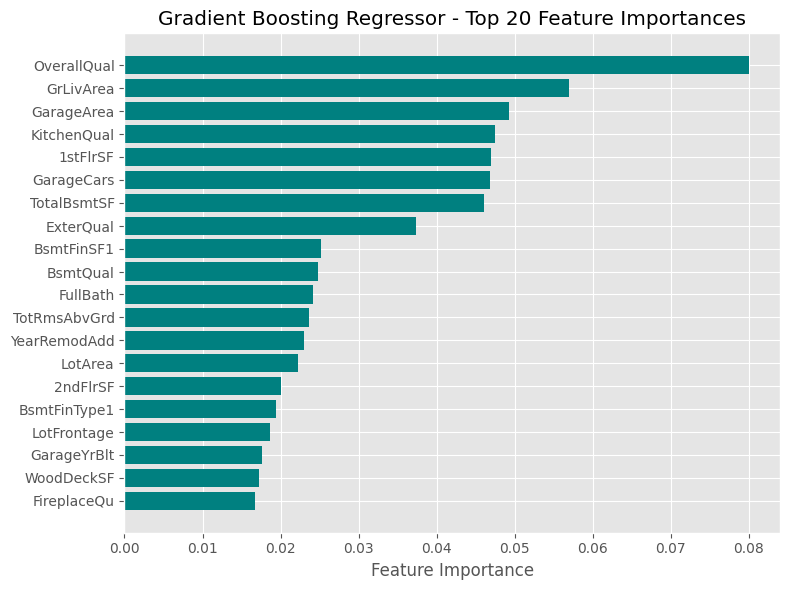

PermutationExplainer explainer: 2580it [07:32,  5.57it/s]                                                              


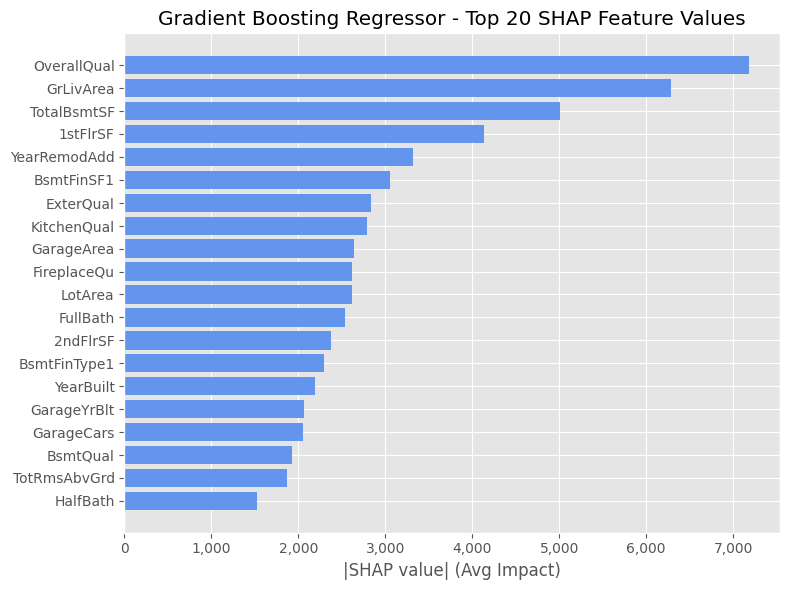

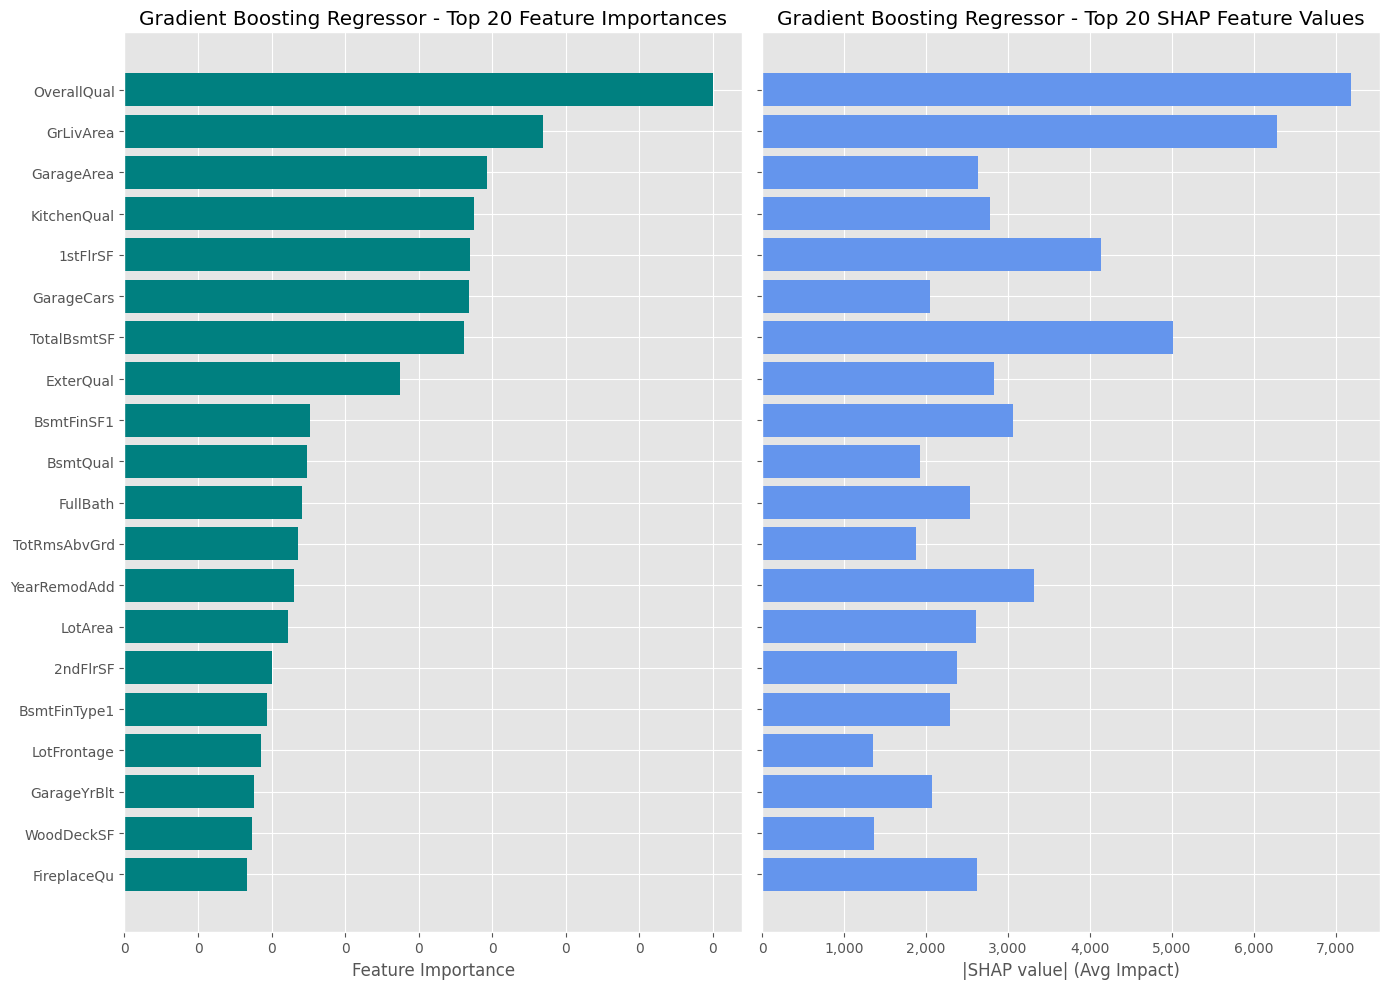

In [99]:
#Gradient Boosting Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_gbm, 'Gradient Boosting Regressor')

In [40]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1)
hgbm_cv_scores = cross_val_score(hgbm, X, Y, cv=5, scoring='r2')
hgbm.fit(X, Y)
hgbm_mean_cv_score = np.mean(hgbm_cv_scores)
print(f'HistGradientBoosting Base Model Mean CV Score: {hgbm_mean_cv_score}')

#Results Dataframe
hgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['HistGradientBoosting'],
    'Mean_R²': [hgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [hgbm_cv_scores[i]] for i in range(5)}
})

Binning 0.004 GB of training data: 0.048 s
Fitting gradient boosted rounds:
Fit 100 trees in 4.944 s, (3100 total leaves)
Time spent computing histograms: 0.844s
Time spent finding best splits:  0.082s
Time spent applying splits:      0.066s
Time spent predicting:           0.004s
Binning 0.004 GB of training data: 0.067 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.313 s, (3100 total leaves)
Time spent computing histograms: 0.758s
Time spent finding best splits:  0.078s
Time spent applying splits:      0.063s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.053 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.343 s, (3100 total leaves)
Time spent computing histograms: 0.772s
Time spent finding best splits:  0.084s
Time spent applying splits:      0.069s
Time spent predicting:           0.004s
Binning 0.004 GB of training data: 0.055 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.294 s, (3100 total leaves)
Time spent computing histograms:

In [9]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X, Y).mean()))

Binning 0.004 GB of training data: 0.068 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.363 s, (3100 total leaves)
Time spent computing histograms: 0.809s
Time spent finding best splits:  0.078s
Time spent applying splits:      0.058s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.055 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.258 s, (3100 total leaves)
Time spent computing histograms: 0.745s
Time spent finding best splits:  0.076s
Time spent applying splits:      0.056s
Time spent predicting:           0.004s
Binning 0.004 GB of training data: 0.054 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.252 s, (3100 total leaves)
Time spent computing histograms: 0.753s
Time spent finding best splits:  0.071s
Time spent applying splits:      0.053s
Time spent predicting:           0.003s
Binning 0.004 GB of training data: 0.052 s
Fitting gradient boosted rounds:
Fit 100 trees in 1.284 s, (3100 total leaves)
Time spent computing histograms:

0.9121093445438377

In [56]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [0.06402125, 0.0641, 0.0642],
    'max_leaf_nodes': [10],
    'max_iter': [224],
    'min_samples_leaf': [15],
    'l2_regularization': [0.0, 0.05],
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

#Results Dataframe
hgbm_cv_results_df = pd.DataFrame(random_search_hgb.cv_results_)
hgbm_best_row = hgbm_cv_results_df.loc[hgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
hgbm_fold_scores = [hgbm_best_row[f'split{i}_test_score'] for i in range(5)]
hgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['HistGradientBoosting'],
    'Mean_R²': [hgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [hgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Binning 0.005 GB of training data: 0.056 s
Fitting gradient boosted rounds:
Fit 224 trees in 0.960 s, (2240 total leaves)
Time spent computing histograms: 0.571s
Time spent finding best splits:  0.068s
Time spent applying splits:      0.035s
Time spent predicting:           0.005s
Best parameters: {'min_samples_leaf': 15, 'max_leaf_nodes': 10, 'max_iter': 224, 'learning_rate': 0.06402125, 'l2_regularization': 0.05}
Best CV Score: 0.9221


Calculating permutation importances for HistGradientBoostingRegressor...
Calculating SHAP values for HistGradientBoostingRegressor...


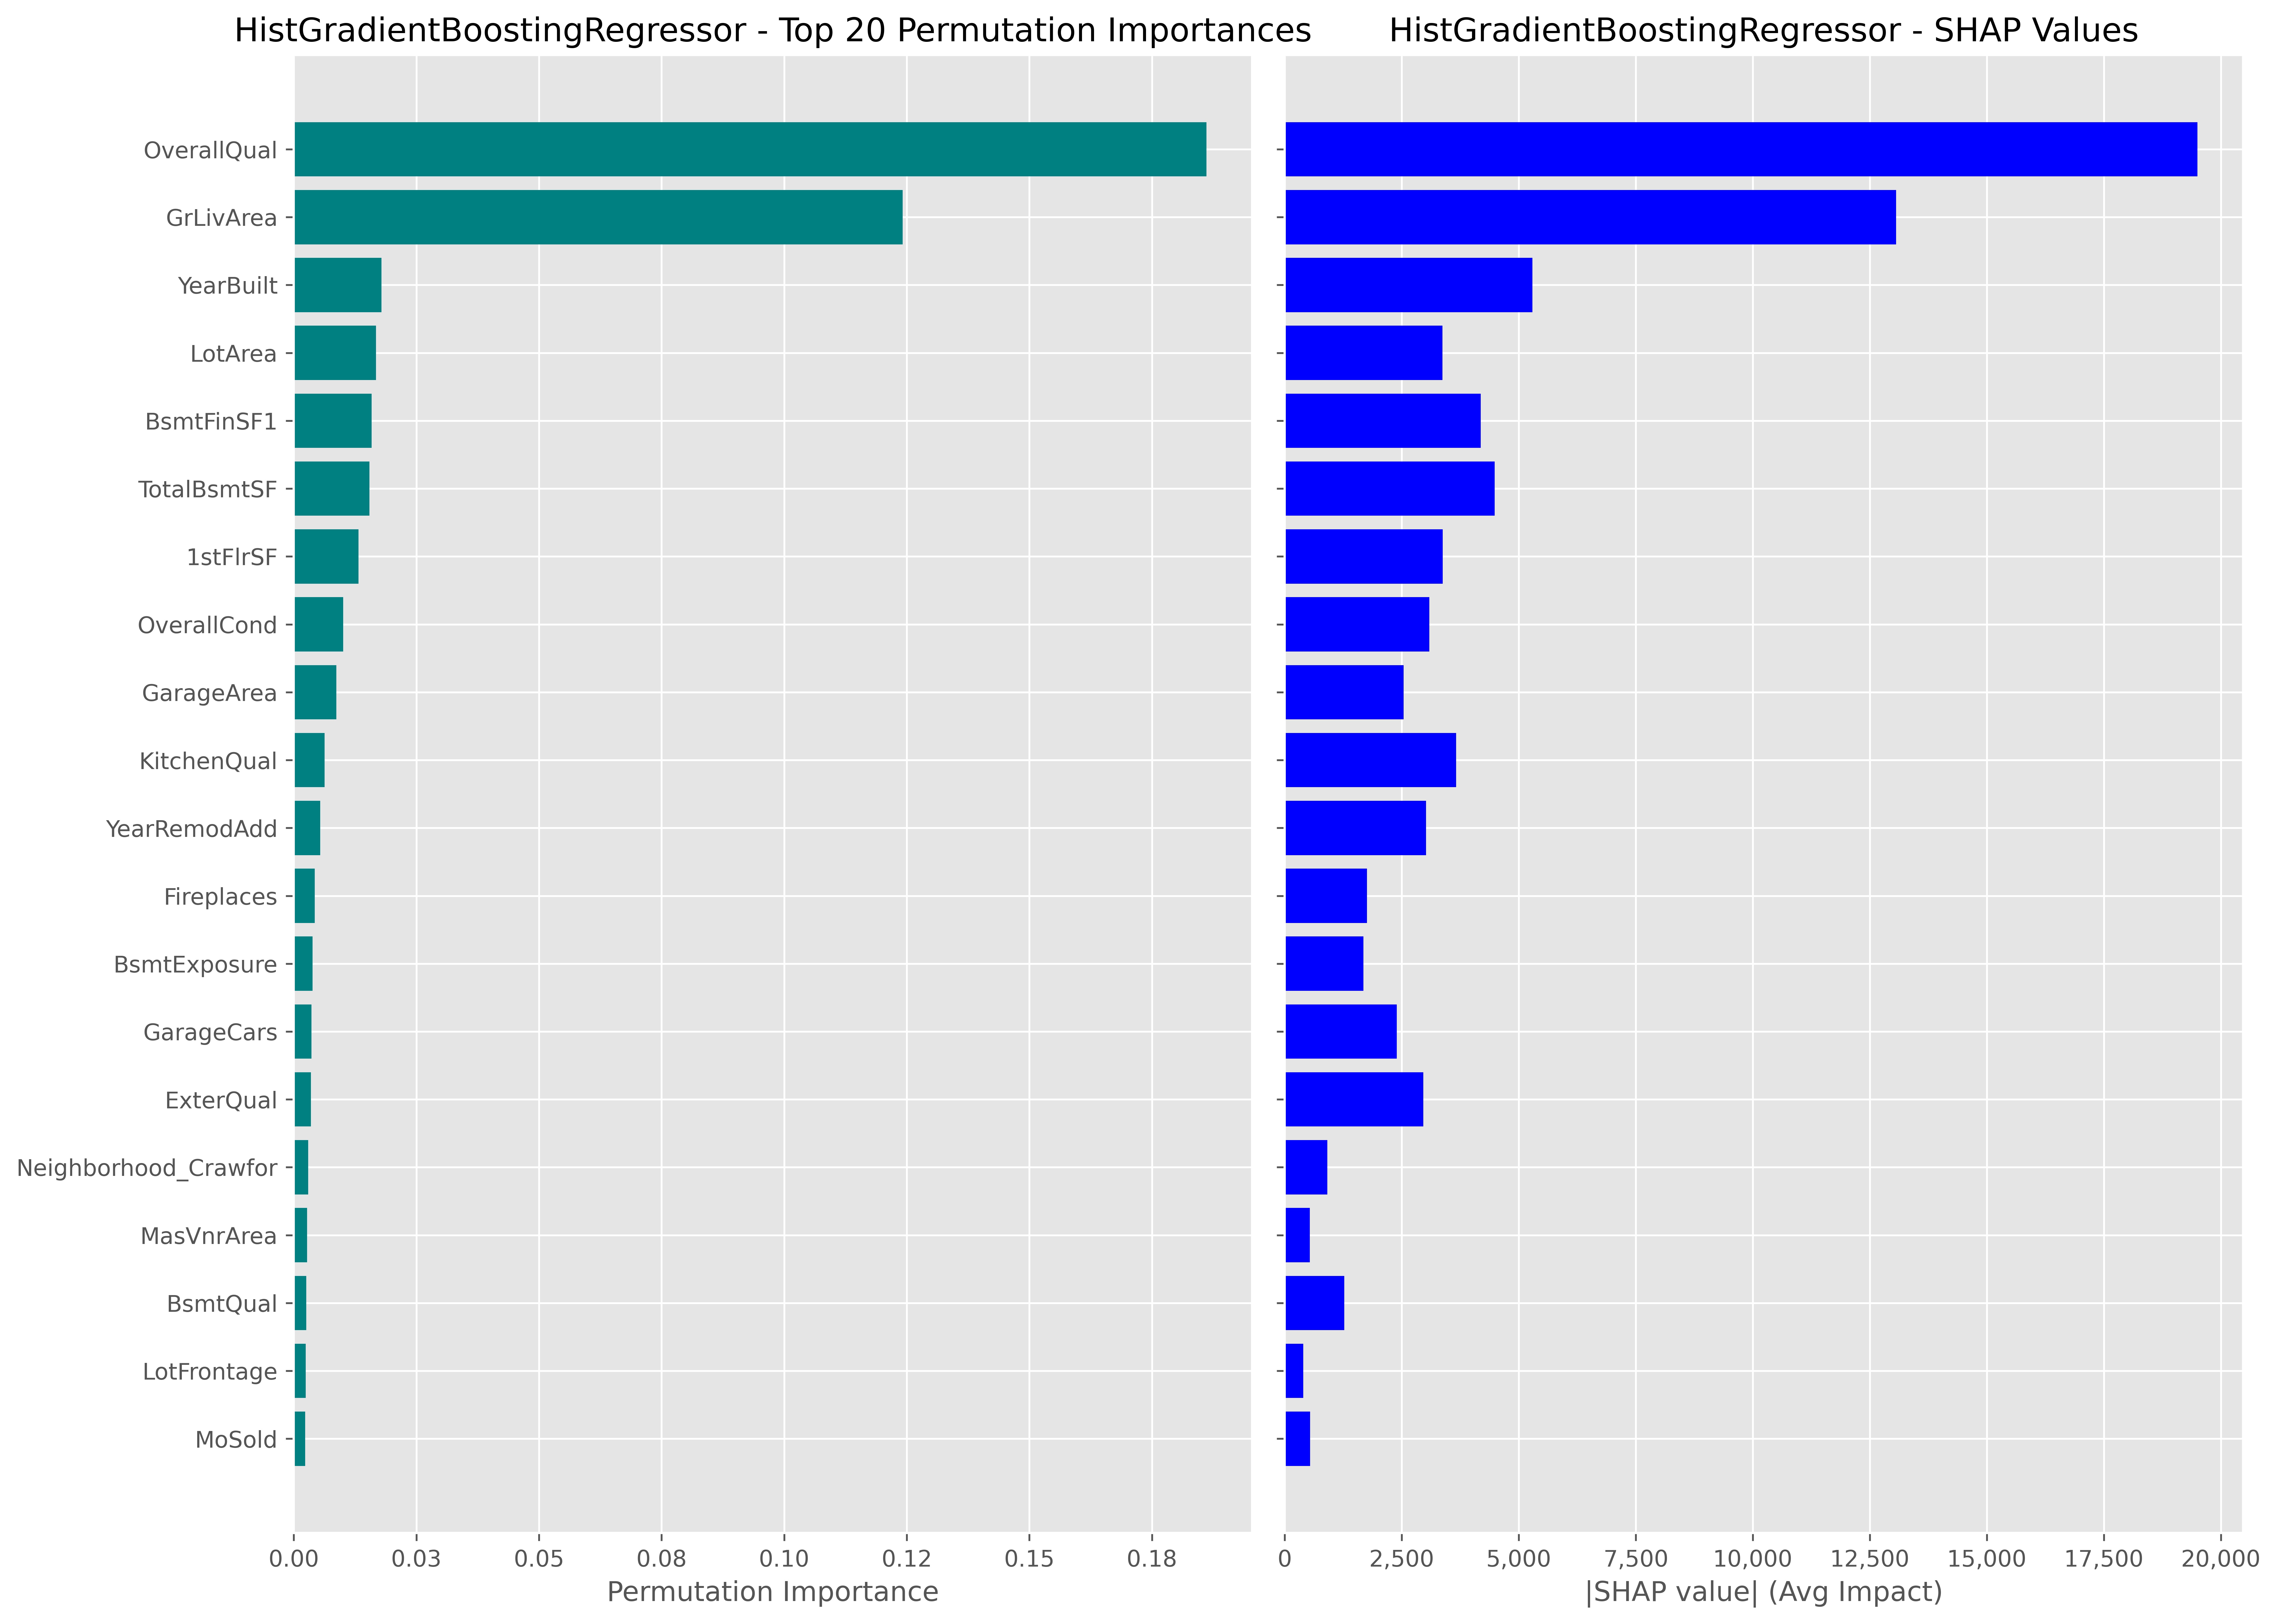

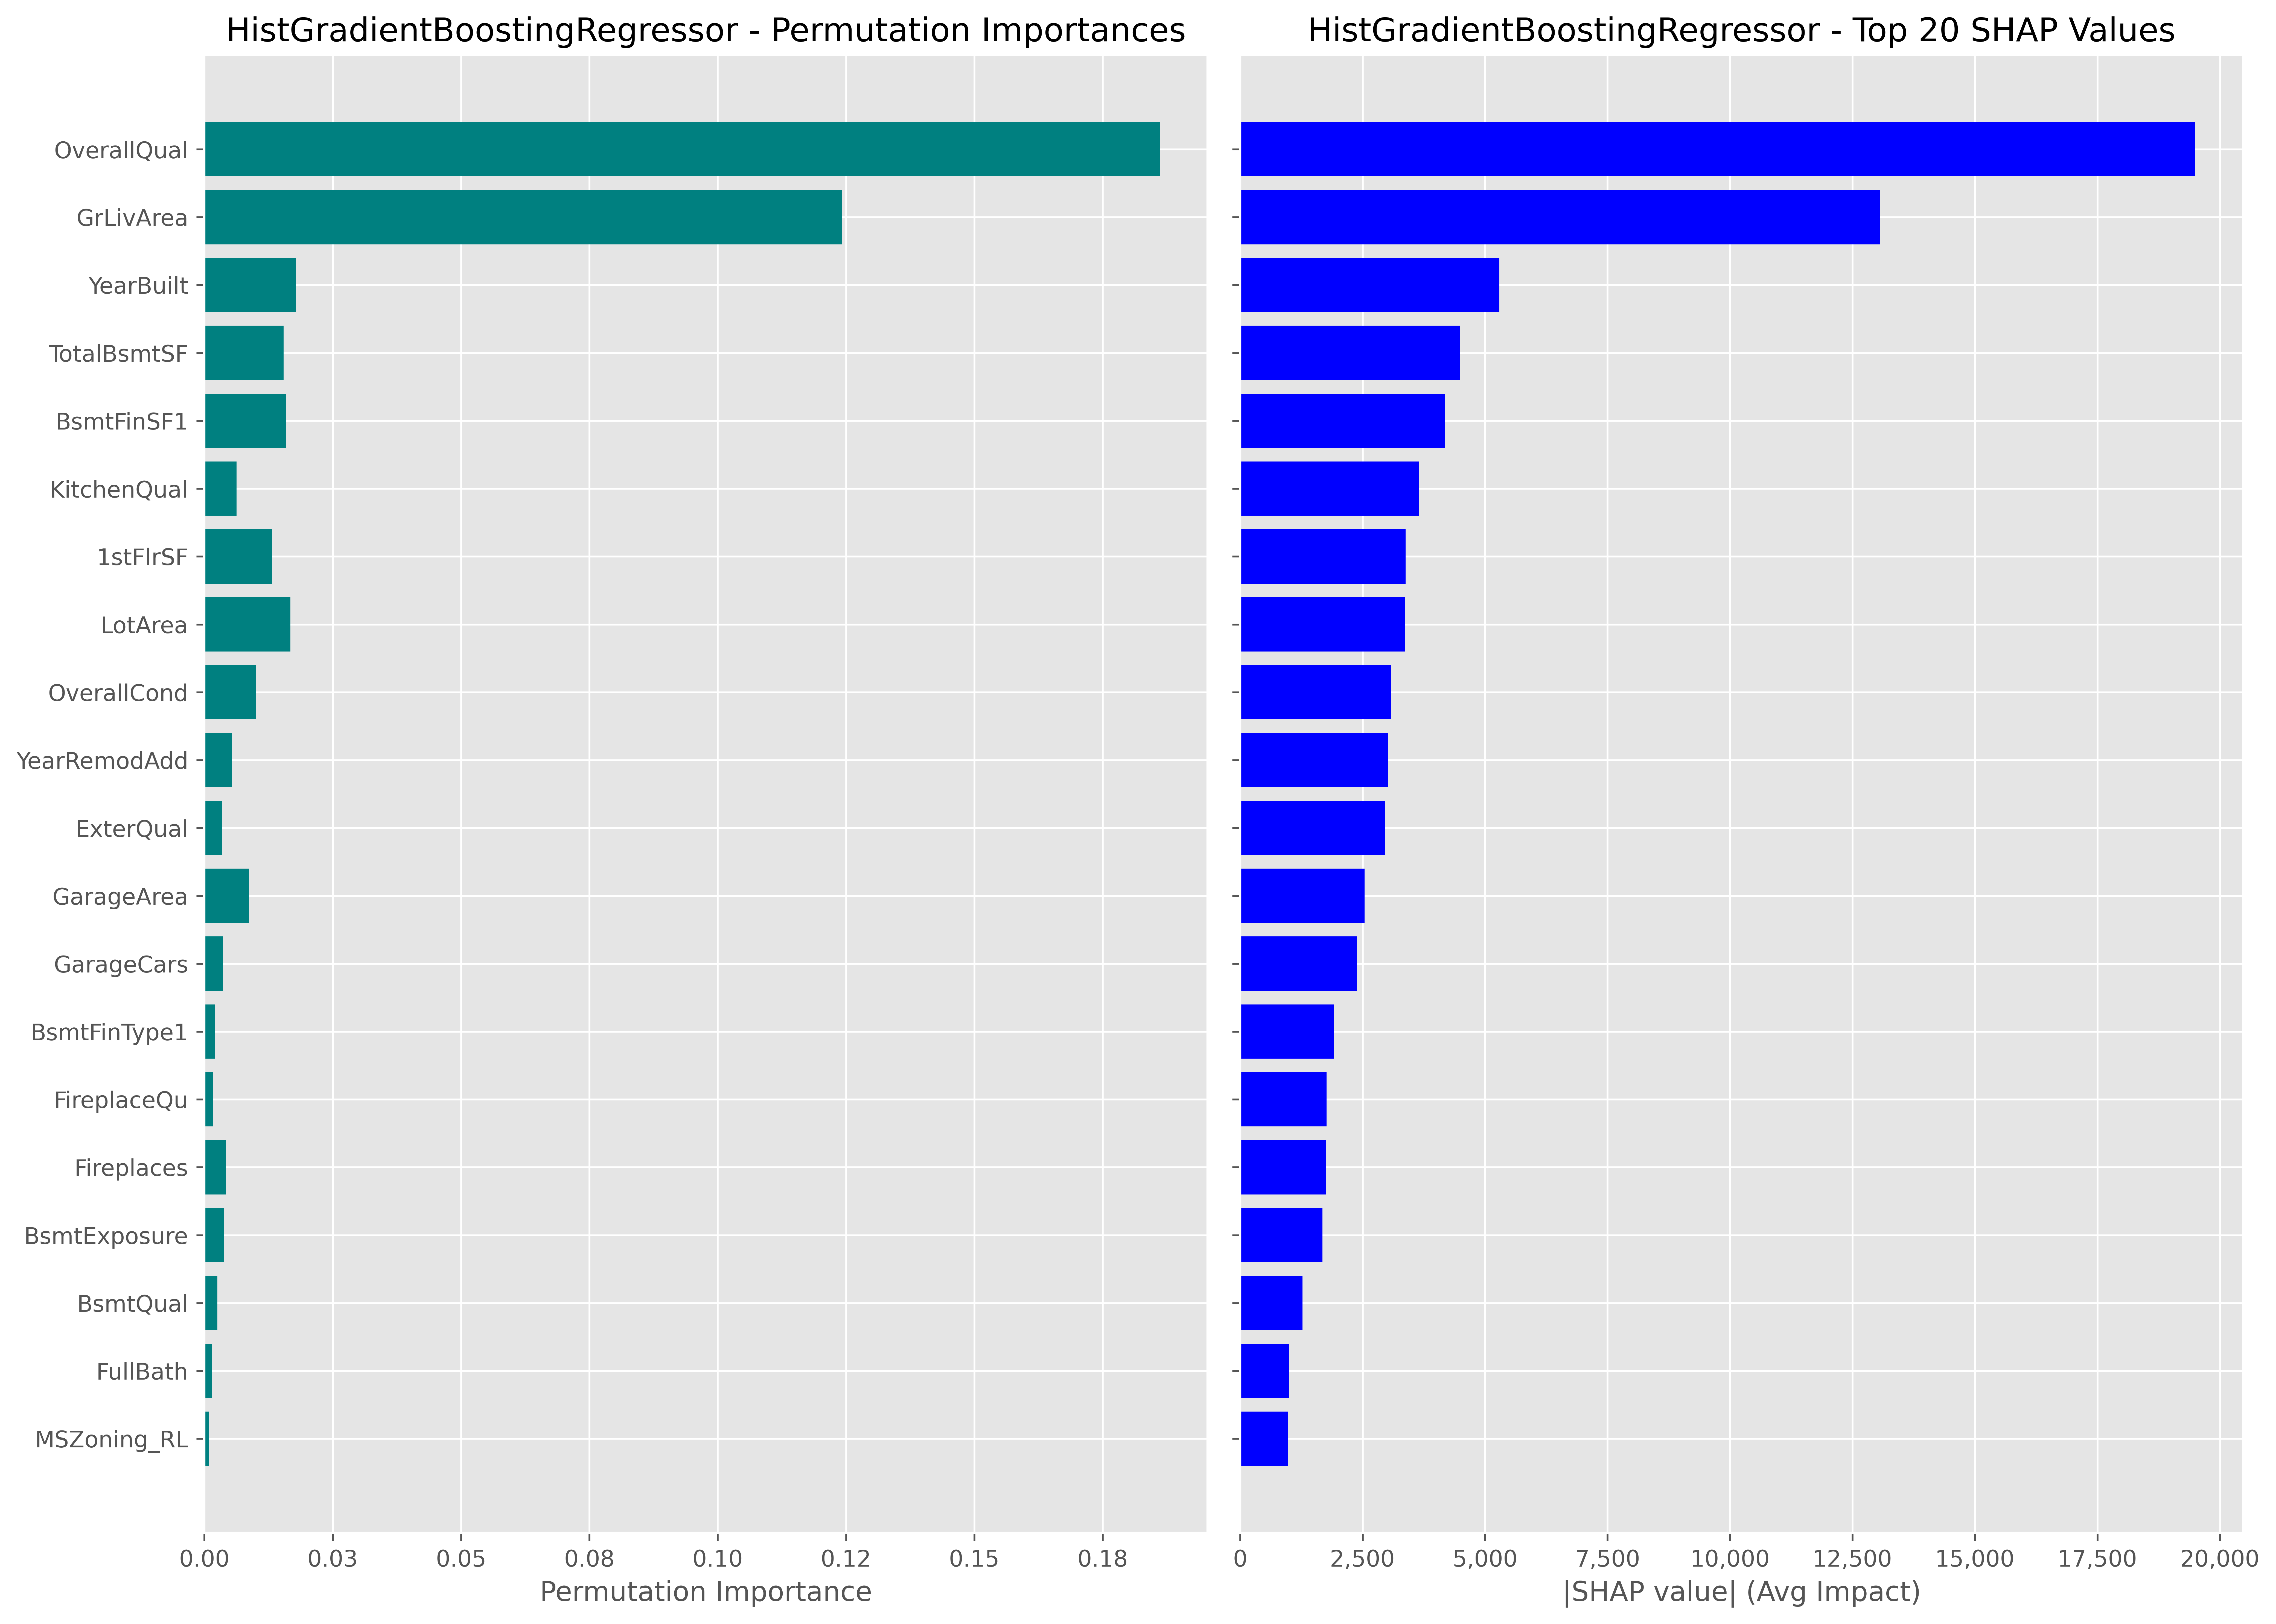


SHAP Beeswarm Plot for HistGradientBoostingRegressor...


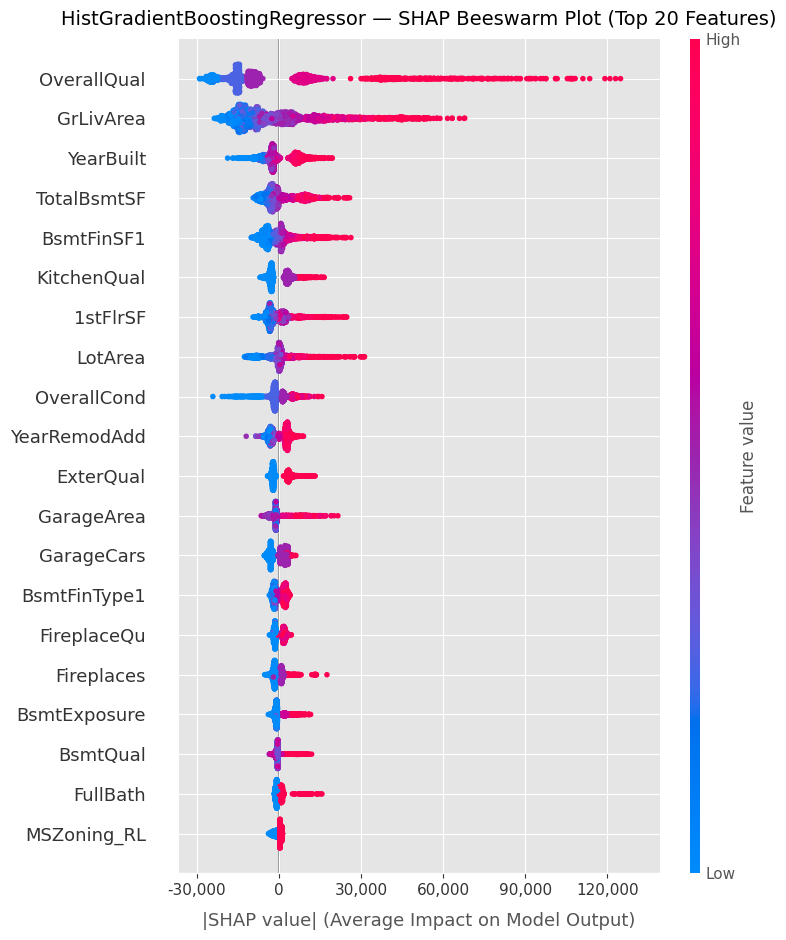

In [11]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_SHAP_Importances(random_search_hgb)

In [42]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm_cv_scores = cross_val_score(xgbm, X, Y, cv=5, scoring='r2')
xgbm.fit(X, Y)
xgbm_mean_cv_score = np.mean(xgbm_cv_scores)
print(f'XGBoost Base Model Mean CV R²: {xgbm_mean_cv_score}')

#Results Dataframe
xgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['XGBoost'],
    'Mean_R²': [xgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [xgbm_cv_scores[i]] for i in range(5)}
})

XGBoost Base Model Mean CV R²: 0.8996396422386169


In [23]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X, Y).mean()))

XGBoost Base Model Score: 0.8996396422386169


In [44]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': np.linspace(0.01, 0.1, 10),
    'subsample': np.linspace(0.1, 1, 10),
    'colsample_bytree': np.linspace(0.1, 1, 10),
    'max_depth': range(2, 11),
    'n_estimators': [50, 125, 200, 275, 350],
    'min_child_weight': range(1, 11),
    'gamma': np.linspace(0, 1, 5),
    'reg_lambda': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 5),
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

#Results Dataframe
xgbm_cv_results_df = pd.DataFrame(random_search_xgbm.cv_results_)
xgbm_best_row = xgbm_cv_results_df.loc[xgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
xgbm_fold_scores = [xgbm_best_row[f'split{i}_test_score'] for i in range(5)]
xgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['XGBoost'],
    'Mean_R²': [xgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [xgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': np.float64(0.9), 'reg_lambda': np.float64(0.25), 'reg_alpha': np.float64(0.5), 'n_estimators': 275, 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': np.float64(0.07), 'gamma': np.float64(0.0), 'colsample_bytree': np.float64(0.30000000000000004)}
Best CV Score: 0.9226


PermutationExplainer explainer: 2580it [03:09, 13.43it/s]                                                              


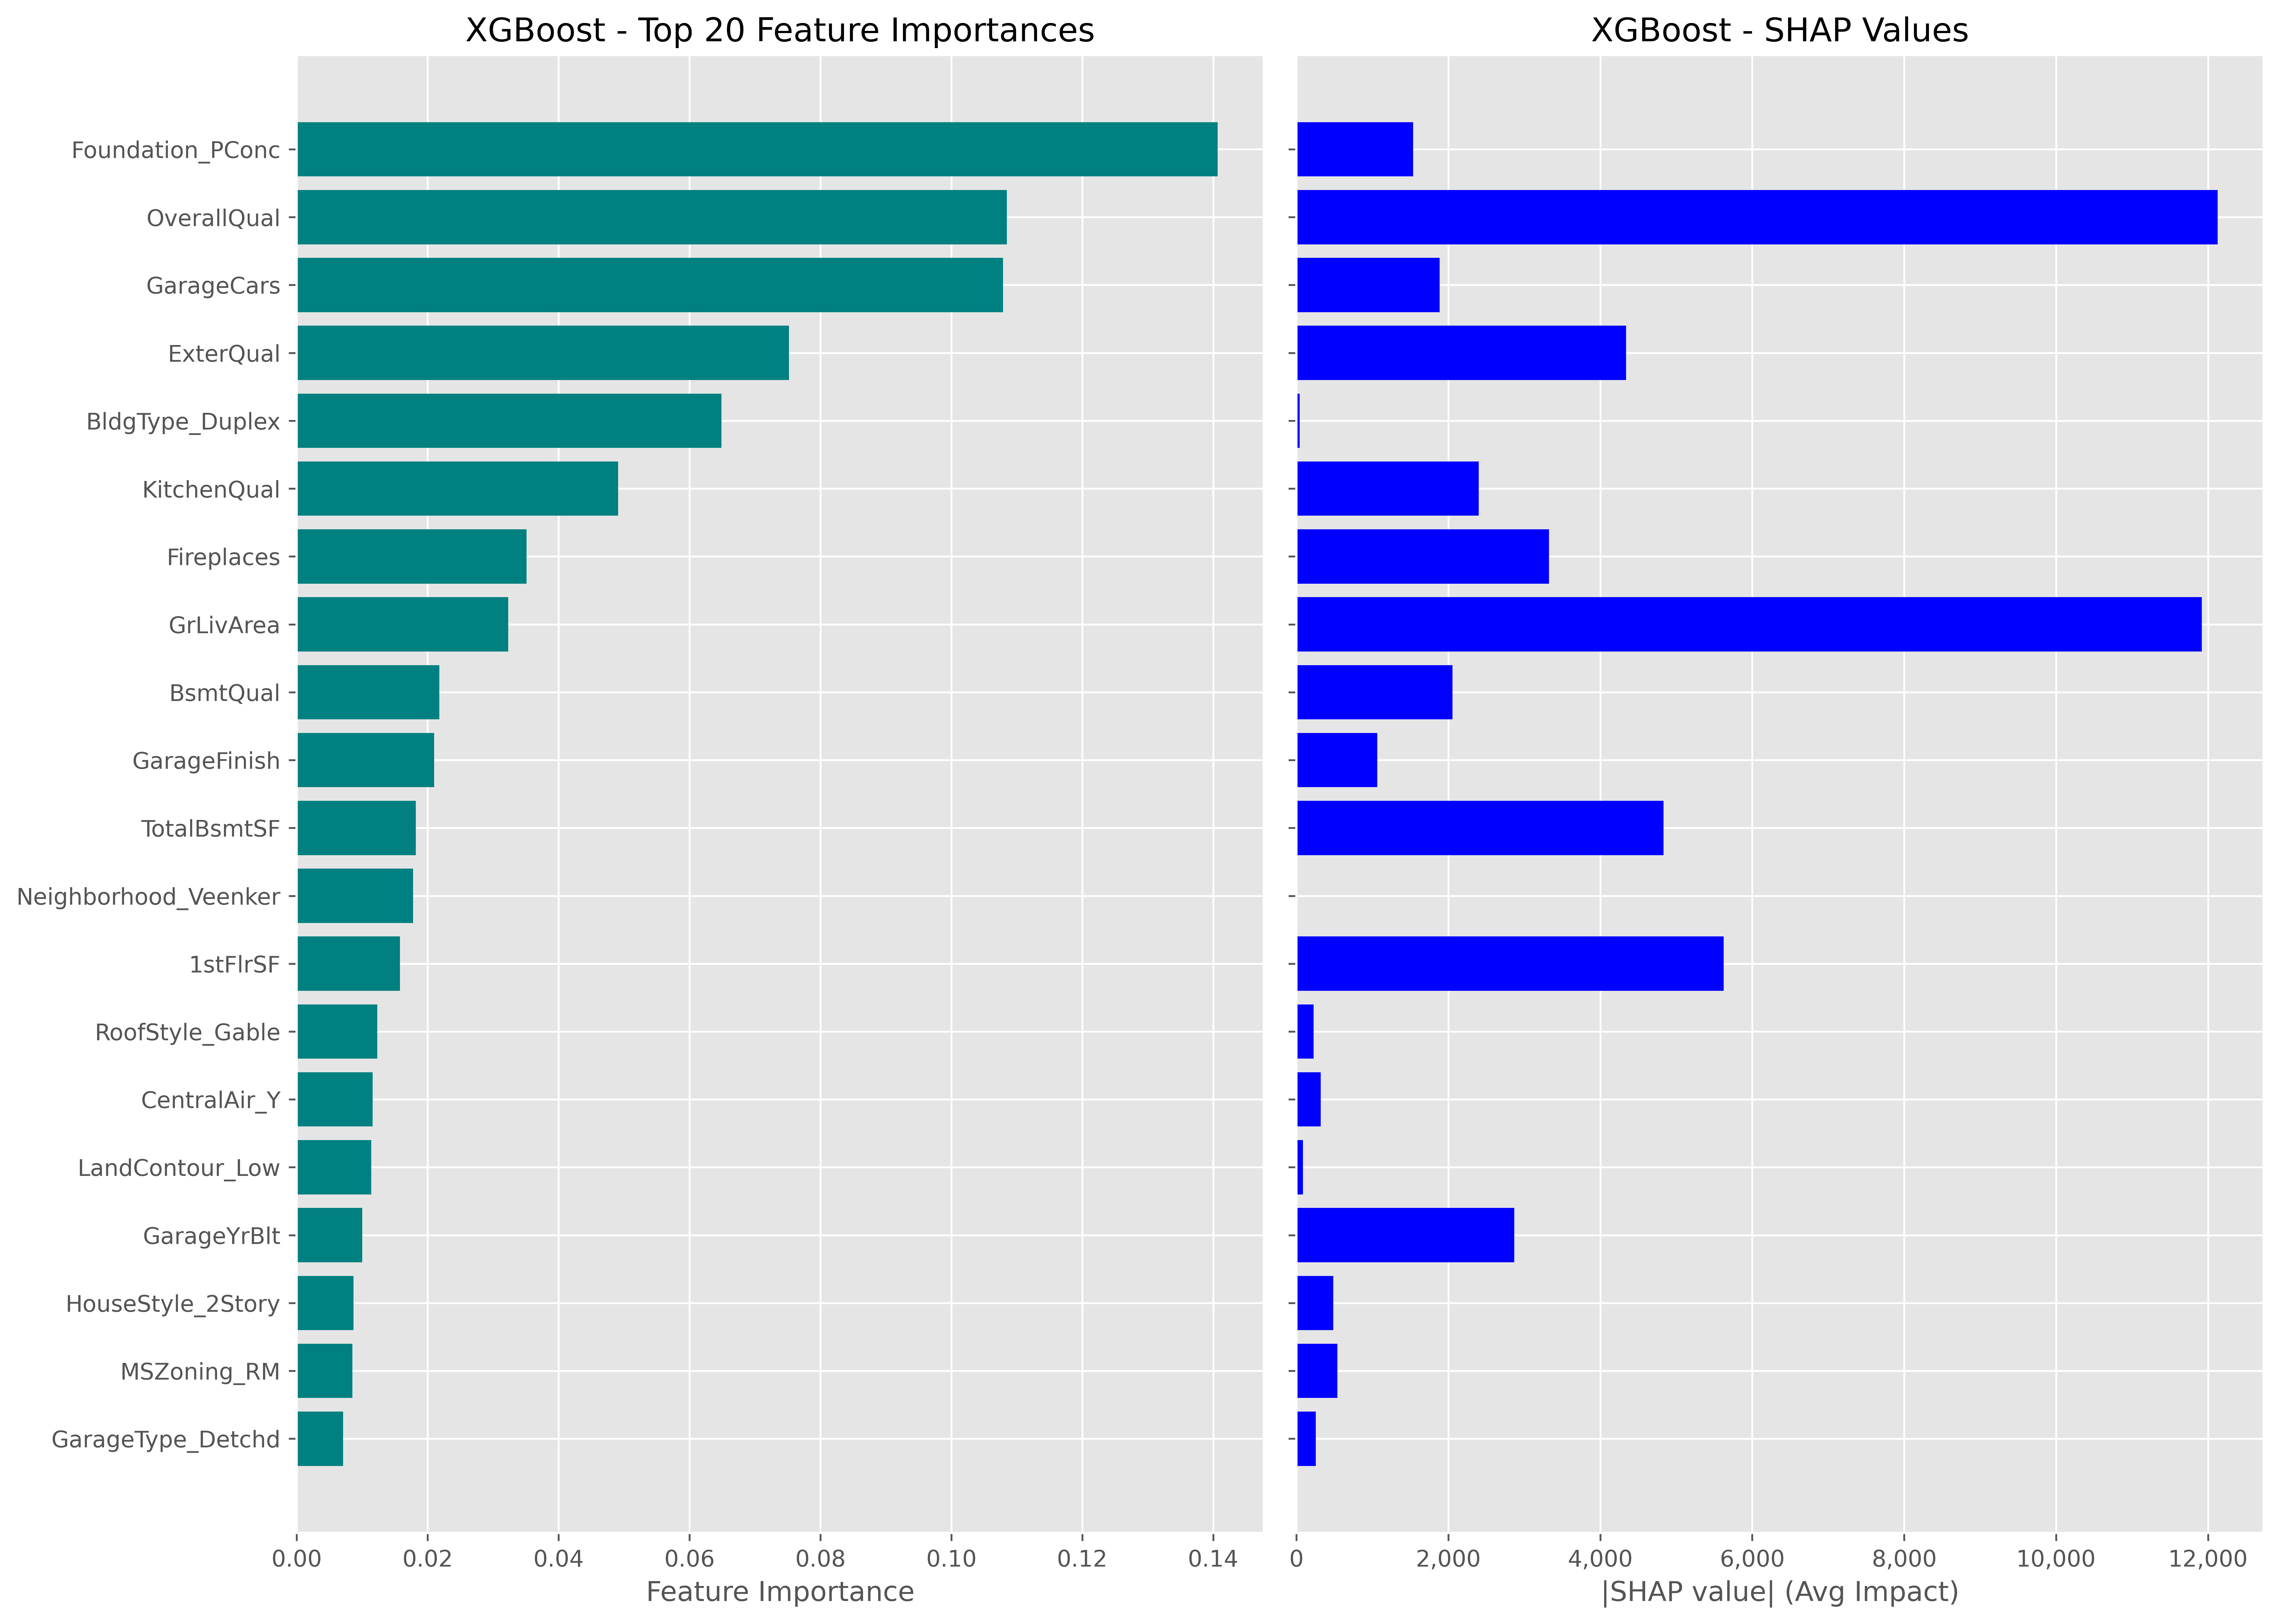

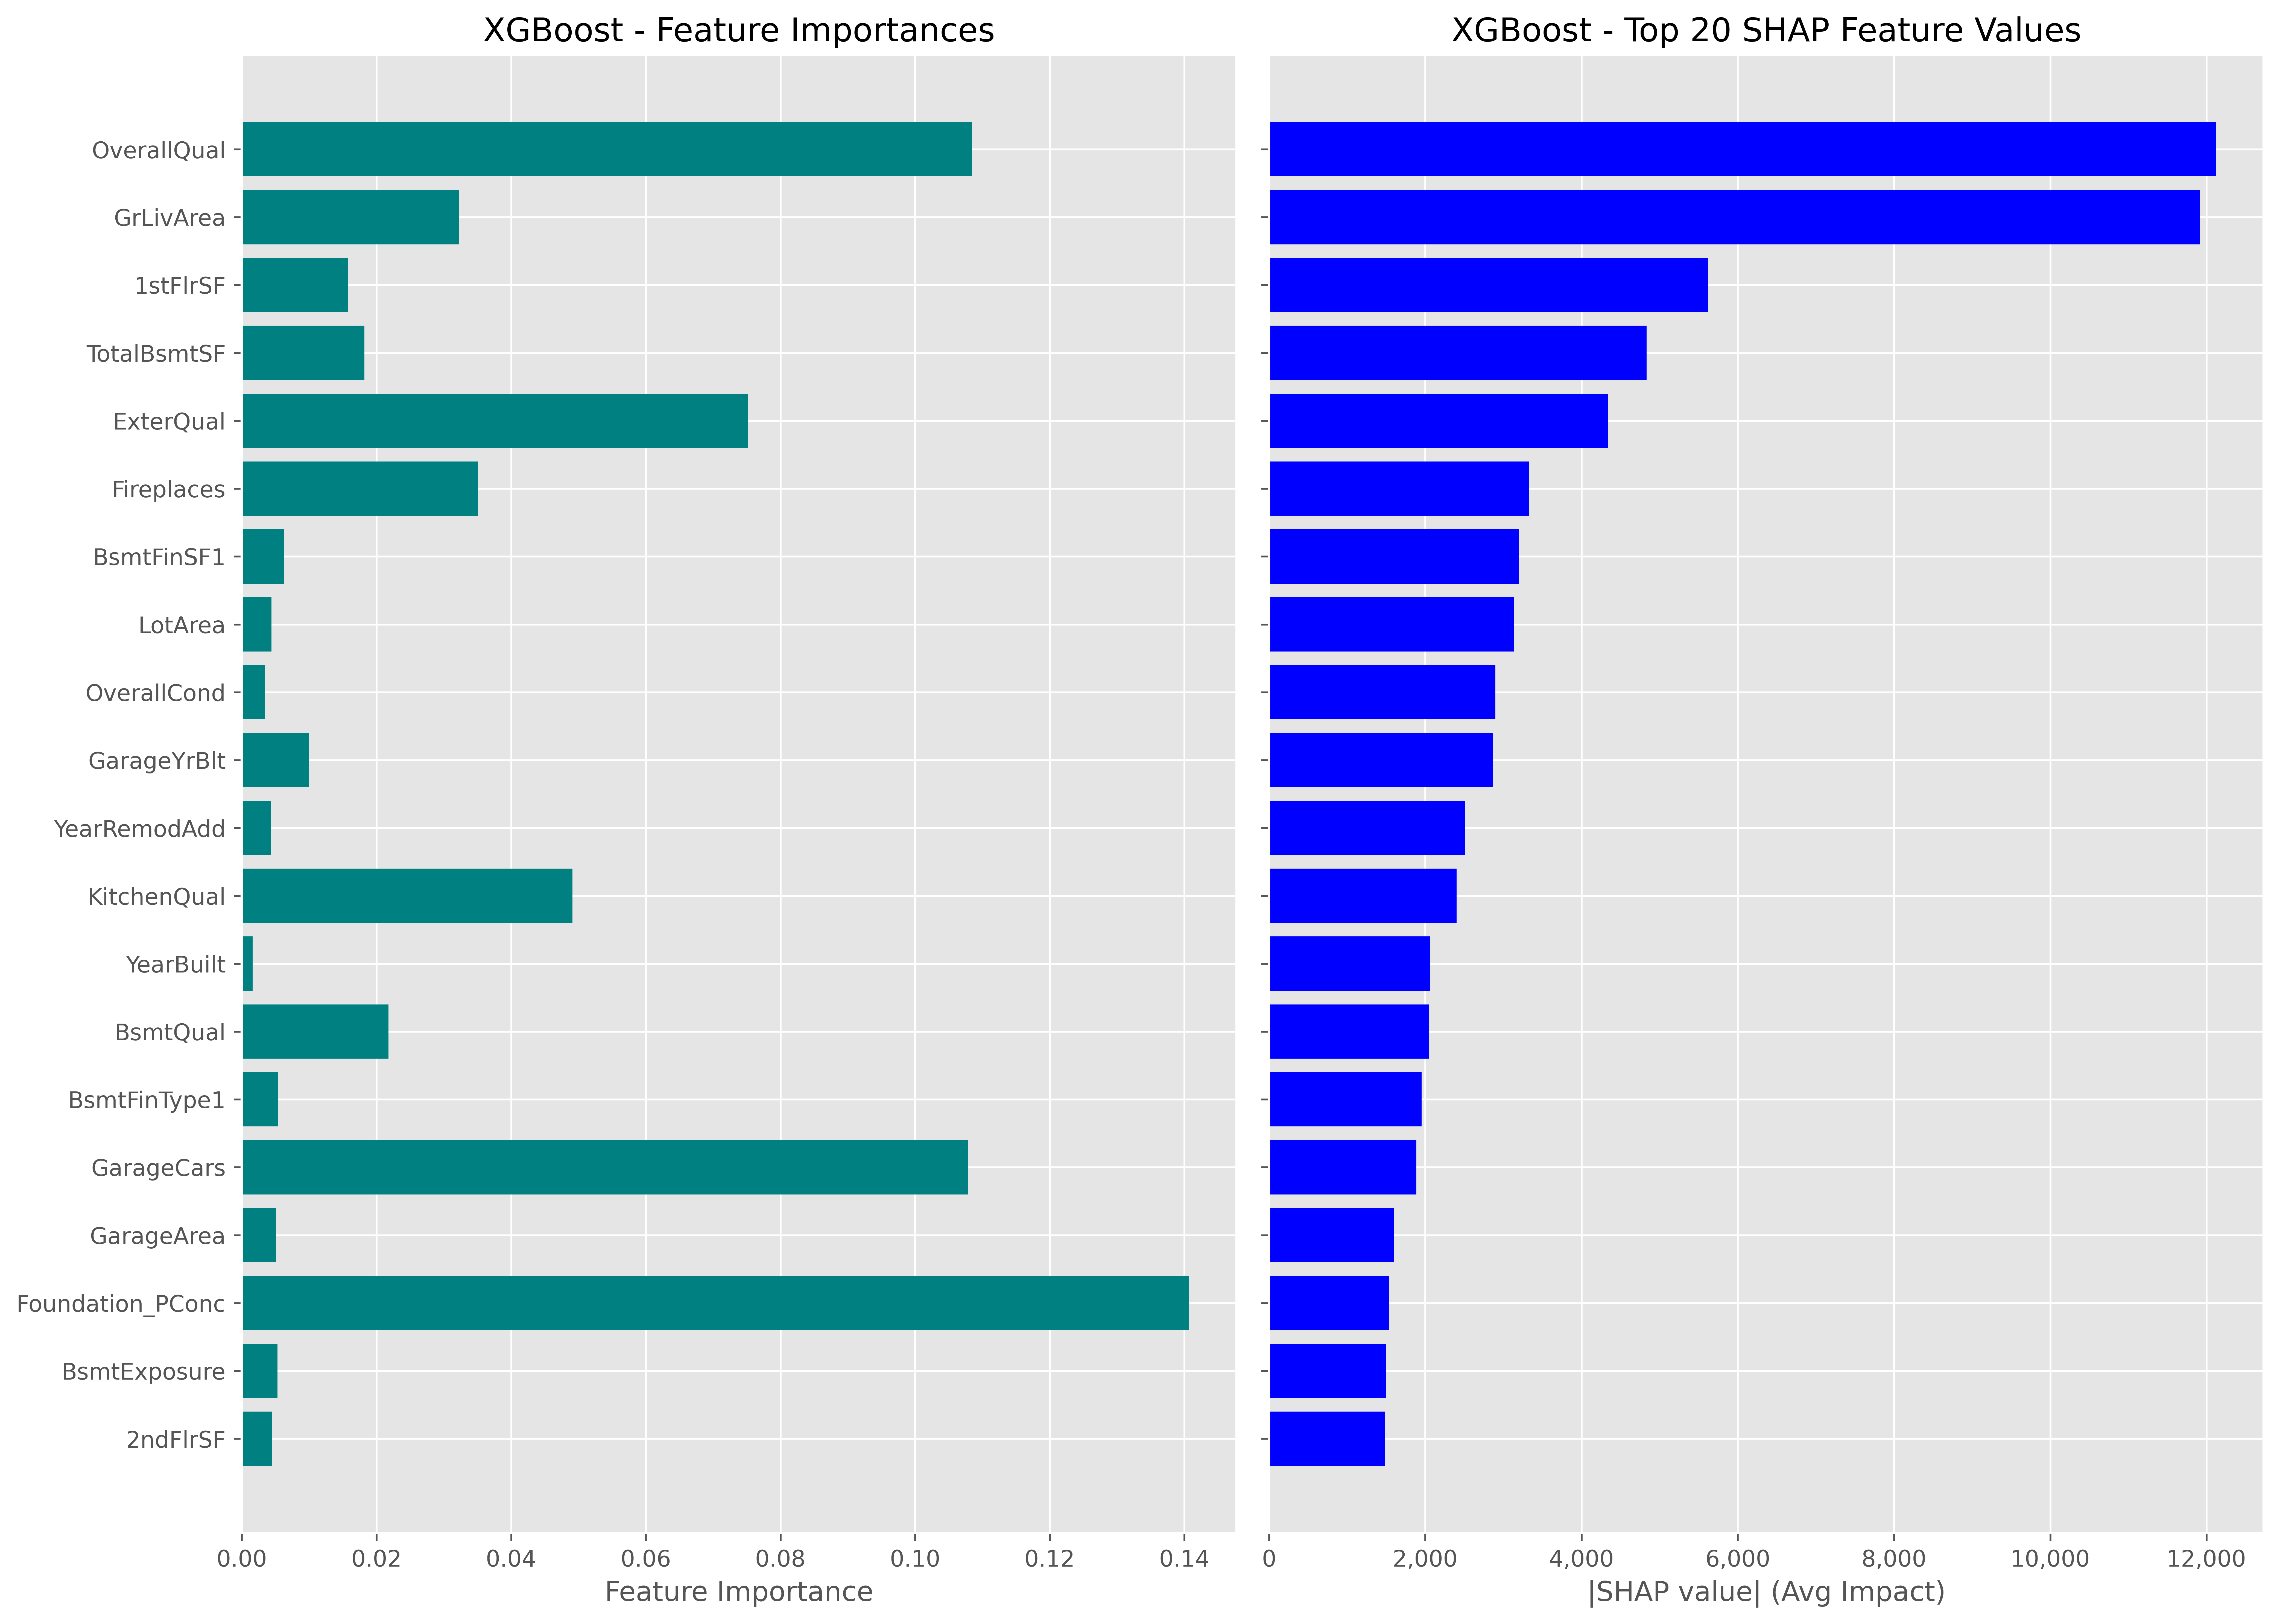


SHAP Beeswarm Plot for XGBoost...


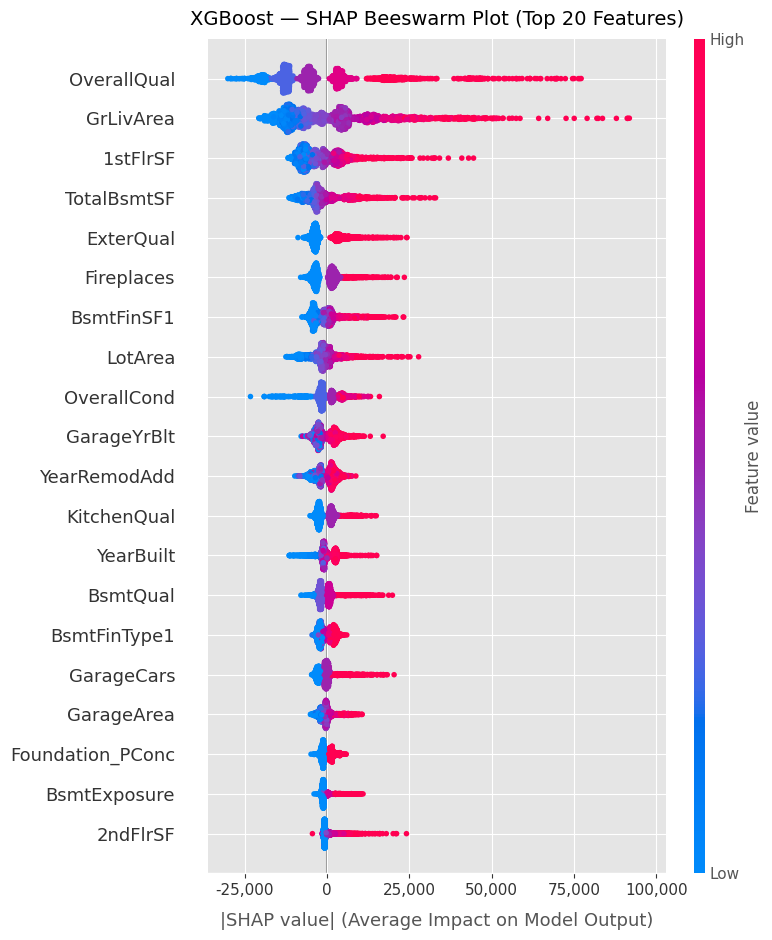

In [21]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_xgbm, 'XGBoost')

In [45]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm_cv_scores = cross_val_score(lgbm, X, Y, cv=5, scoring='r2')
lgbm.fit(X, Y)
lgbm_mean_cv_score = np.mean(lgbm_cv_scores)
print(f'LightGBM Base Model Mean CV R²: {lgbm_mean_cv_score}')

#Results Datarame
lgbm_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['LightGBM'],
    'Mean_R²': [lgbm_mean_cv_score],
    **{f'Fold_{i+1}_R²': [lgbm_cv_scores[i]] for i in range(5)}
})

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 165
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3851
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 164
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [25]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X, Y).mean()))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 165
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3851
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 164
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the over

In [48]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [.25, .5, .75, 1],
    'colsample_bytree': [.25, .5, .75, 1],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_lambda': [0.0, 0.33, 0.67, 1],
    'reg_alpha': [0.0, 0.33, 0.67, 1]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

#Results Dataframe
lgbm_cv_results_df = pd.DataFrame(random_search_lgbm.cv_results_)
lgbm_best_row = lgbm_cv_results_df.loc[lgbm_cv_results_df['rank_test_score'] == 1].iloc[0]
lgbm_fold_scores = [lgbm_best_row[f'split{i}_test_score'] for i in range(5)]
lgbm_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['LightGBM'],
    'Mean_R²': [lgbm_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [lgbm_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3909
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 158
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 1, 'reg_lambda': 0.67, 'reg_alpha': 0.0, 'num_leaves': 31, 'n_estimators': 150, 'min_child_samples': 30, 'max_depth': 99, 'learning_rate': 0.1, 'colsample_bytree': 0.25}
Best CV Score: 0.9211


 97%|=================== | 2502/2579 [00:28<00:00]       

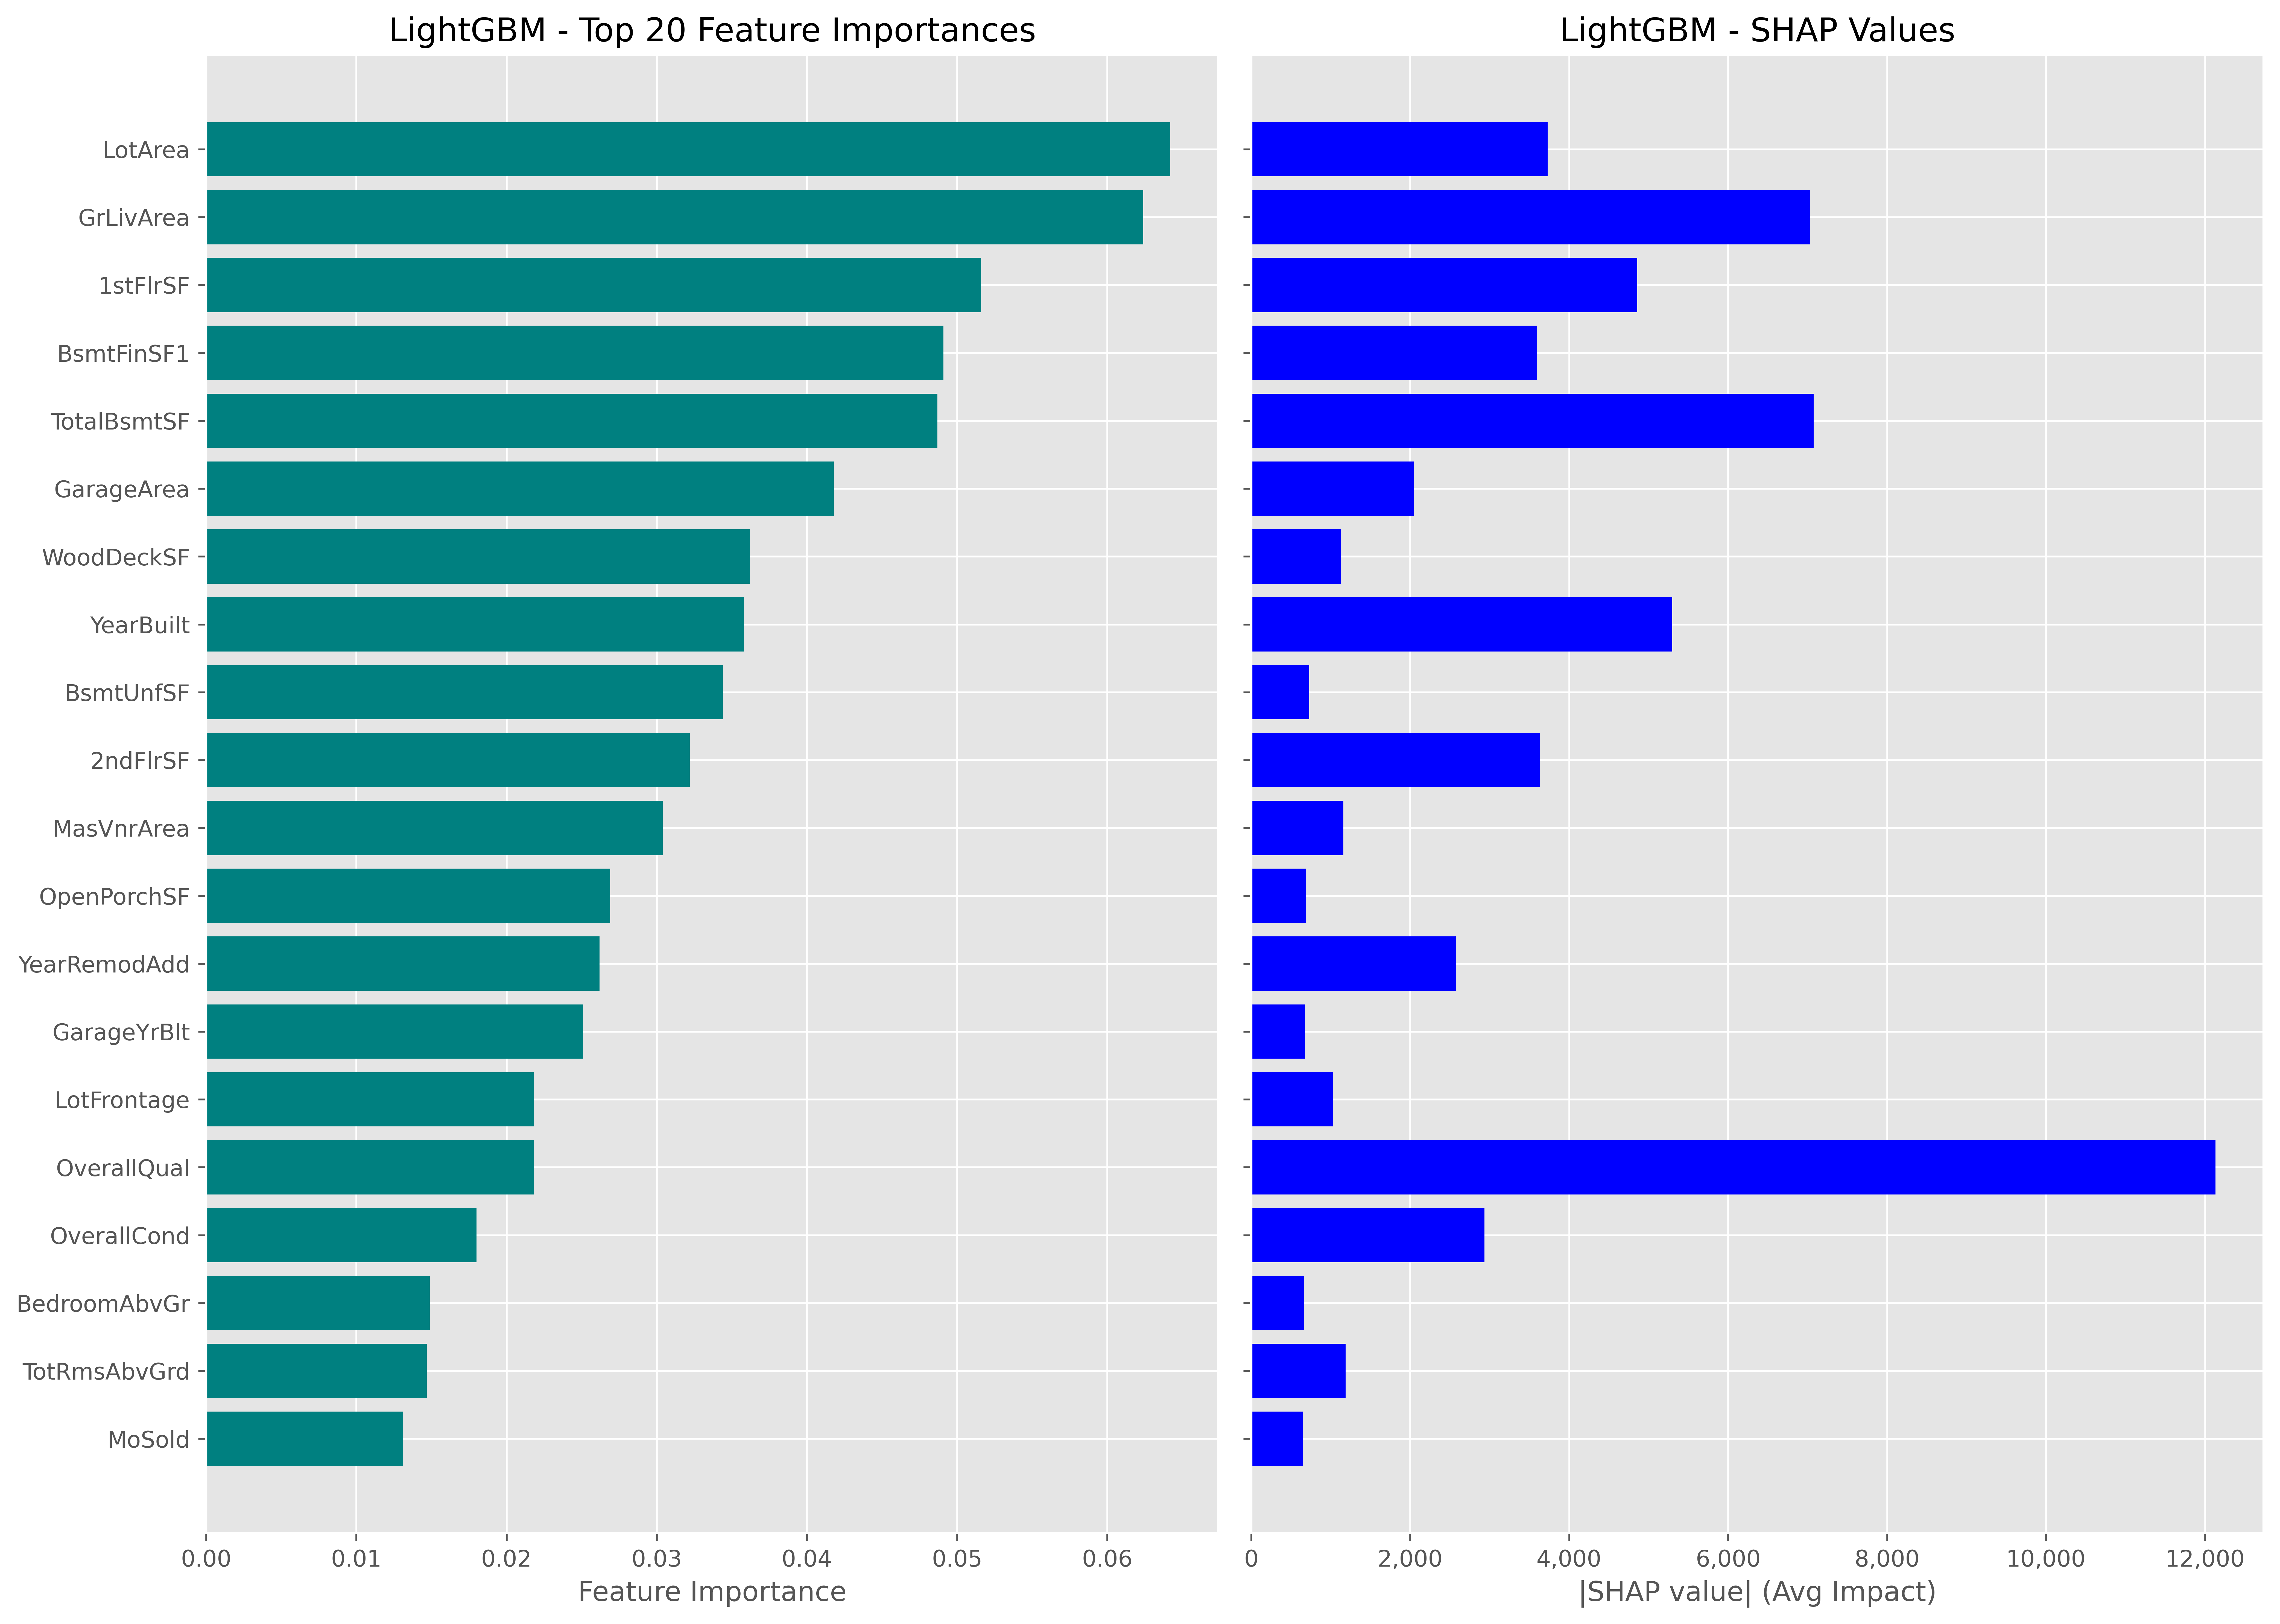

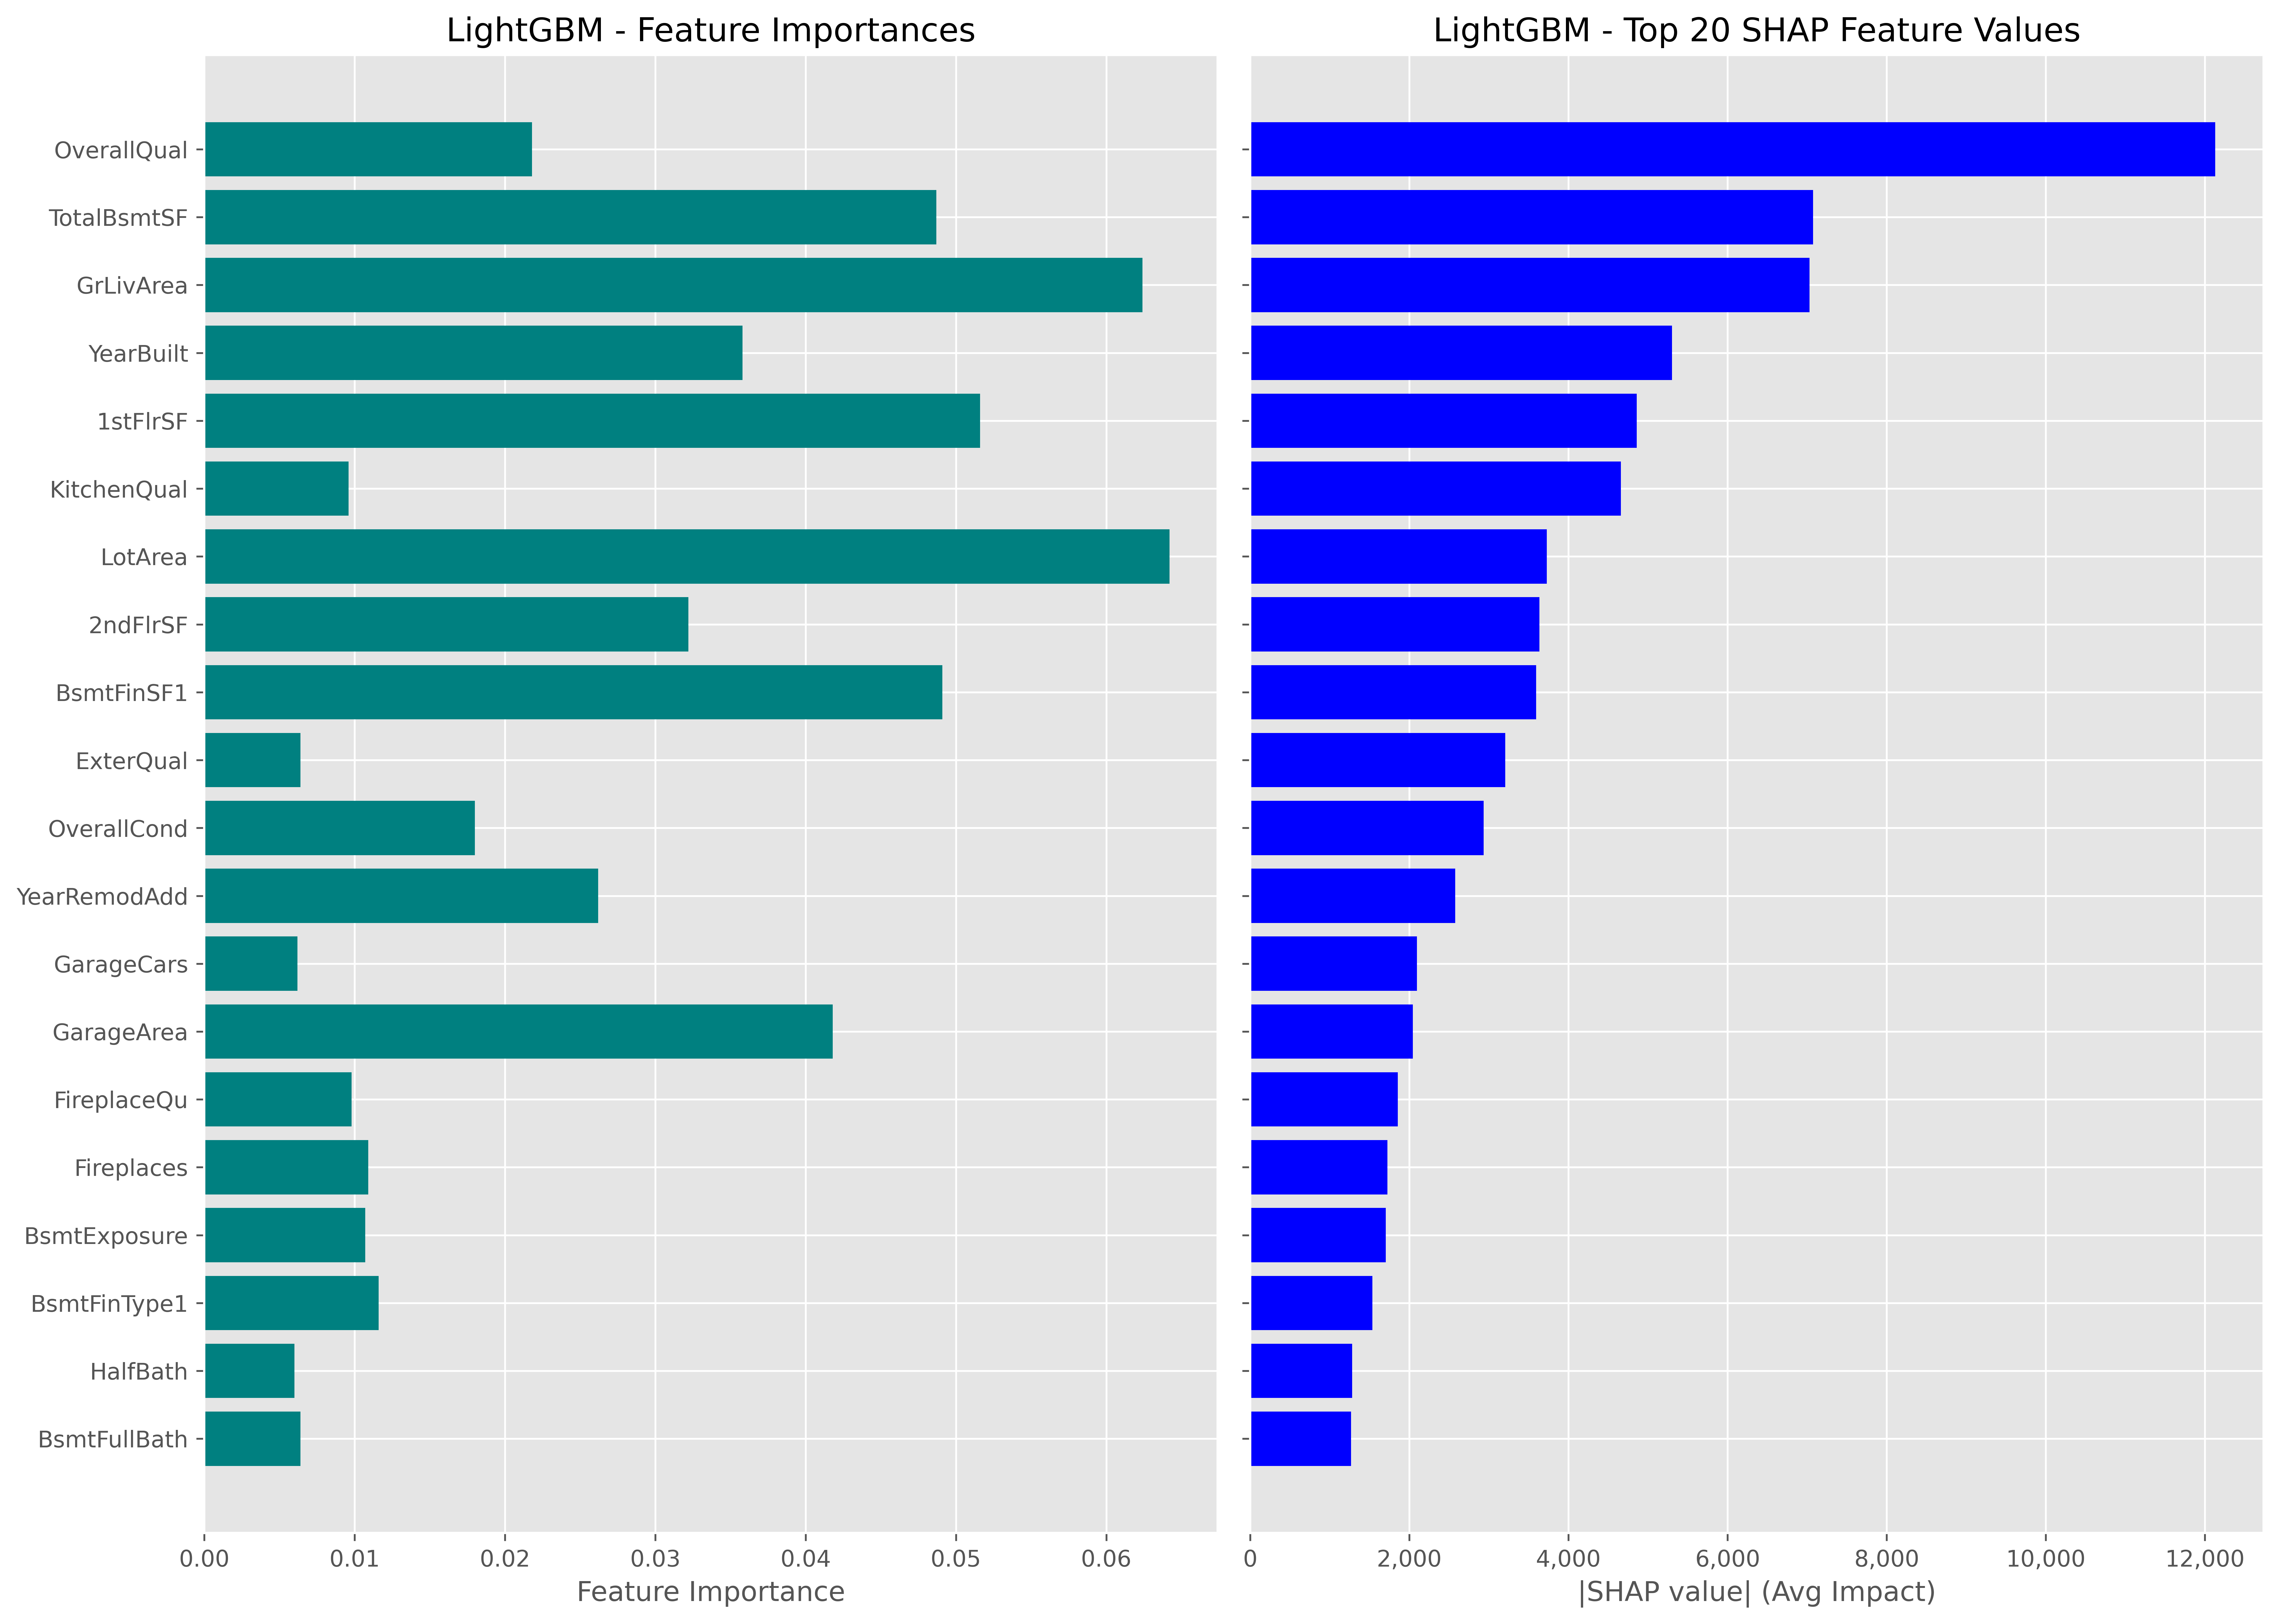


SHAP Beeswarm Plot for LightGBM...


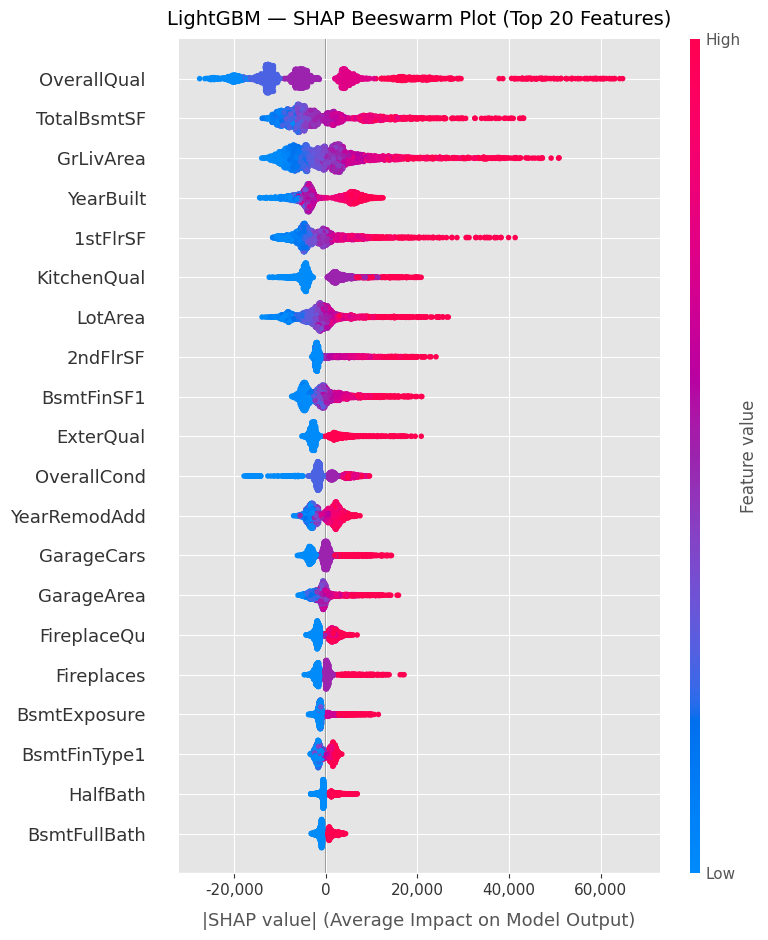

In [31]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm, 'LightGBM')

In [49]:
lgbm_GOSS = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1, boosting_type='goss')
lgbm_GOSS_cv_scores = cross_val_score(lgbm_GOSS, X, Y, cv=5, scoring='r2')
lgbm_GOSS.fit(X, Y)
lgbm_GOSS_mean_cv_score = np.mean(lgbm_GOSS_cv_scores)
print(f'LightGBM GOSS Base Model Mean CV R²: {lgbm_GOSS_mean_cv_score}')

#Results Dataframe
lgbm_GOSS_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['LightGBM_GOSS'],
    'Mean_R²': [lgbm_GOSS_mean_cv_score],
    **{f'Fold_{i+1}_R²': [lgbm_GOSS_cv_scores[i]] for i in range(5)}
})

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 165
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [9]:
print('LightGBM GOSS Base Model Score:', float(cross_val_score(lgbm_GOSS, X, Y).mean()))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3839
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 165
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

In [50]:
#Initial LightGBM GOSS RandomizedSearchCV for faster estimates
lgbm_GOSS_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [.25, .5, .75, 1],
    'colsample_bytree': [.25, .5, .75, 1],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_lambda': [0.0, 0.33, 0.67, 1],
    'reg_alpha': [0.0, 0.33, 0.67, 1]
}
random_search_lgbm_GOSS = RandomizedSearchCV(
    estimator=lgbm_GOSS,
    param_distributions=lgbm_GOSS_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm_GOSS.fit(X, Y)
print('Best parameters:', random_search_lgbm_GOSS.best_params_)
print(f'Best CV Score: {random_search_lgbm_GOSS.best_score_:.4f}')

#Results Dataframe
lgbm_GOSS_cv_results_df = pd.DataFrame(random_search_lgbm_GOSS.cv_results_)
lgbm_GOSS_best_row = lgbm_GOSS_cv_results_df.loc[lgbm_GOSS_cv_results_df['rank_test_score'] == 1].iloc[0]
lgbm_GOSS_fold_scores = [lgbm_GOSS_best_row[f'split{i}_test_score'] for i in range(5)]
lgbm_GOSS_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['LightGBM_GOSS'],
    'Mean_R²': [lgbm_GOSS_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [lgbm_GOSS_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3975
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 191
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 0.5, 'reg_lambda': 0.0, '

100%|===================| 2571/2579 [00:12<00:00]        

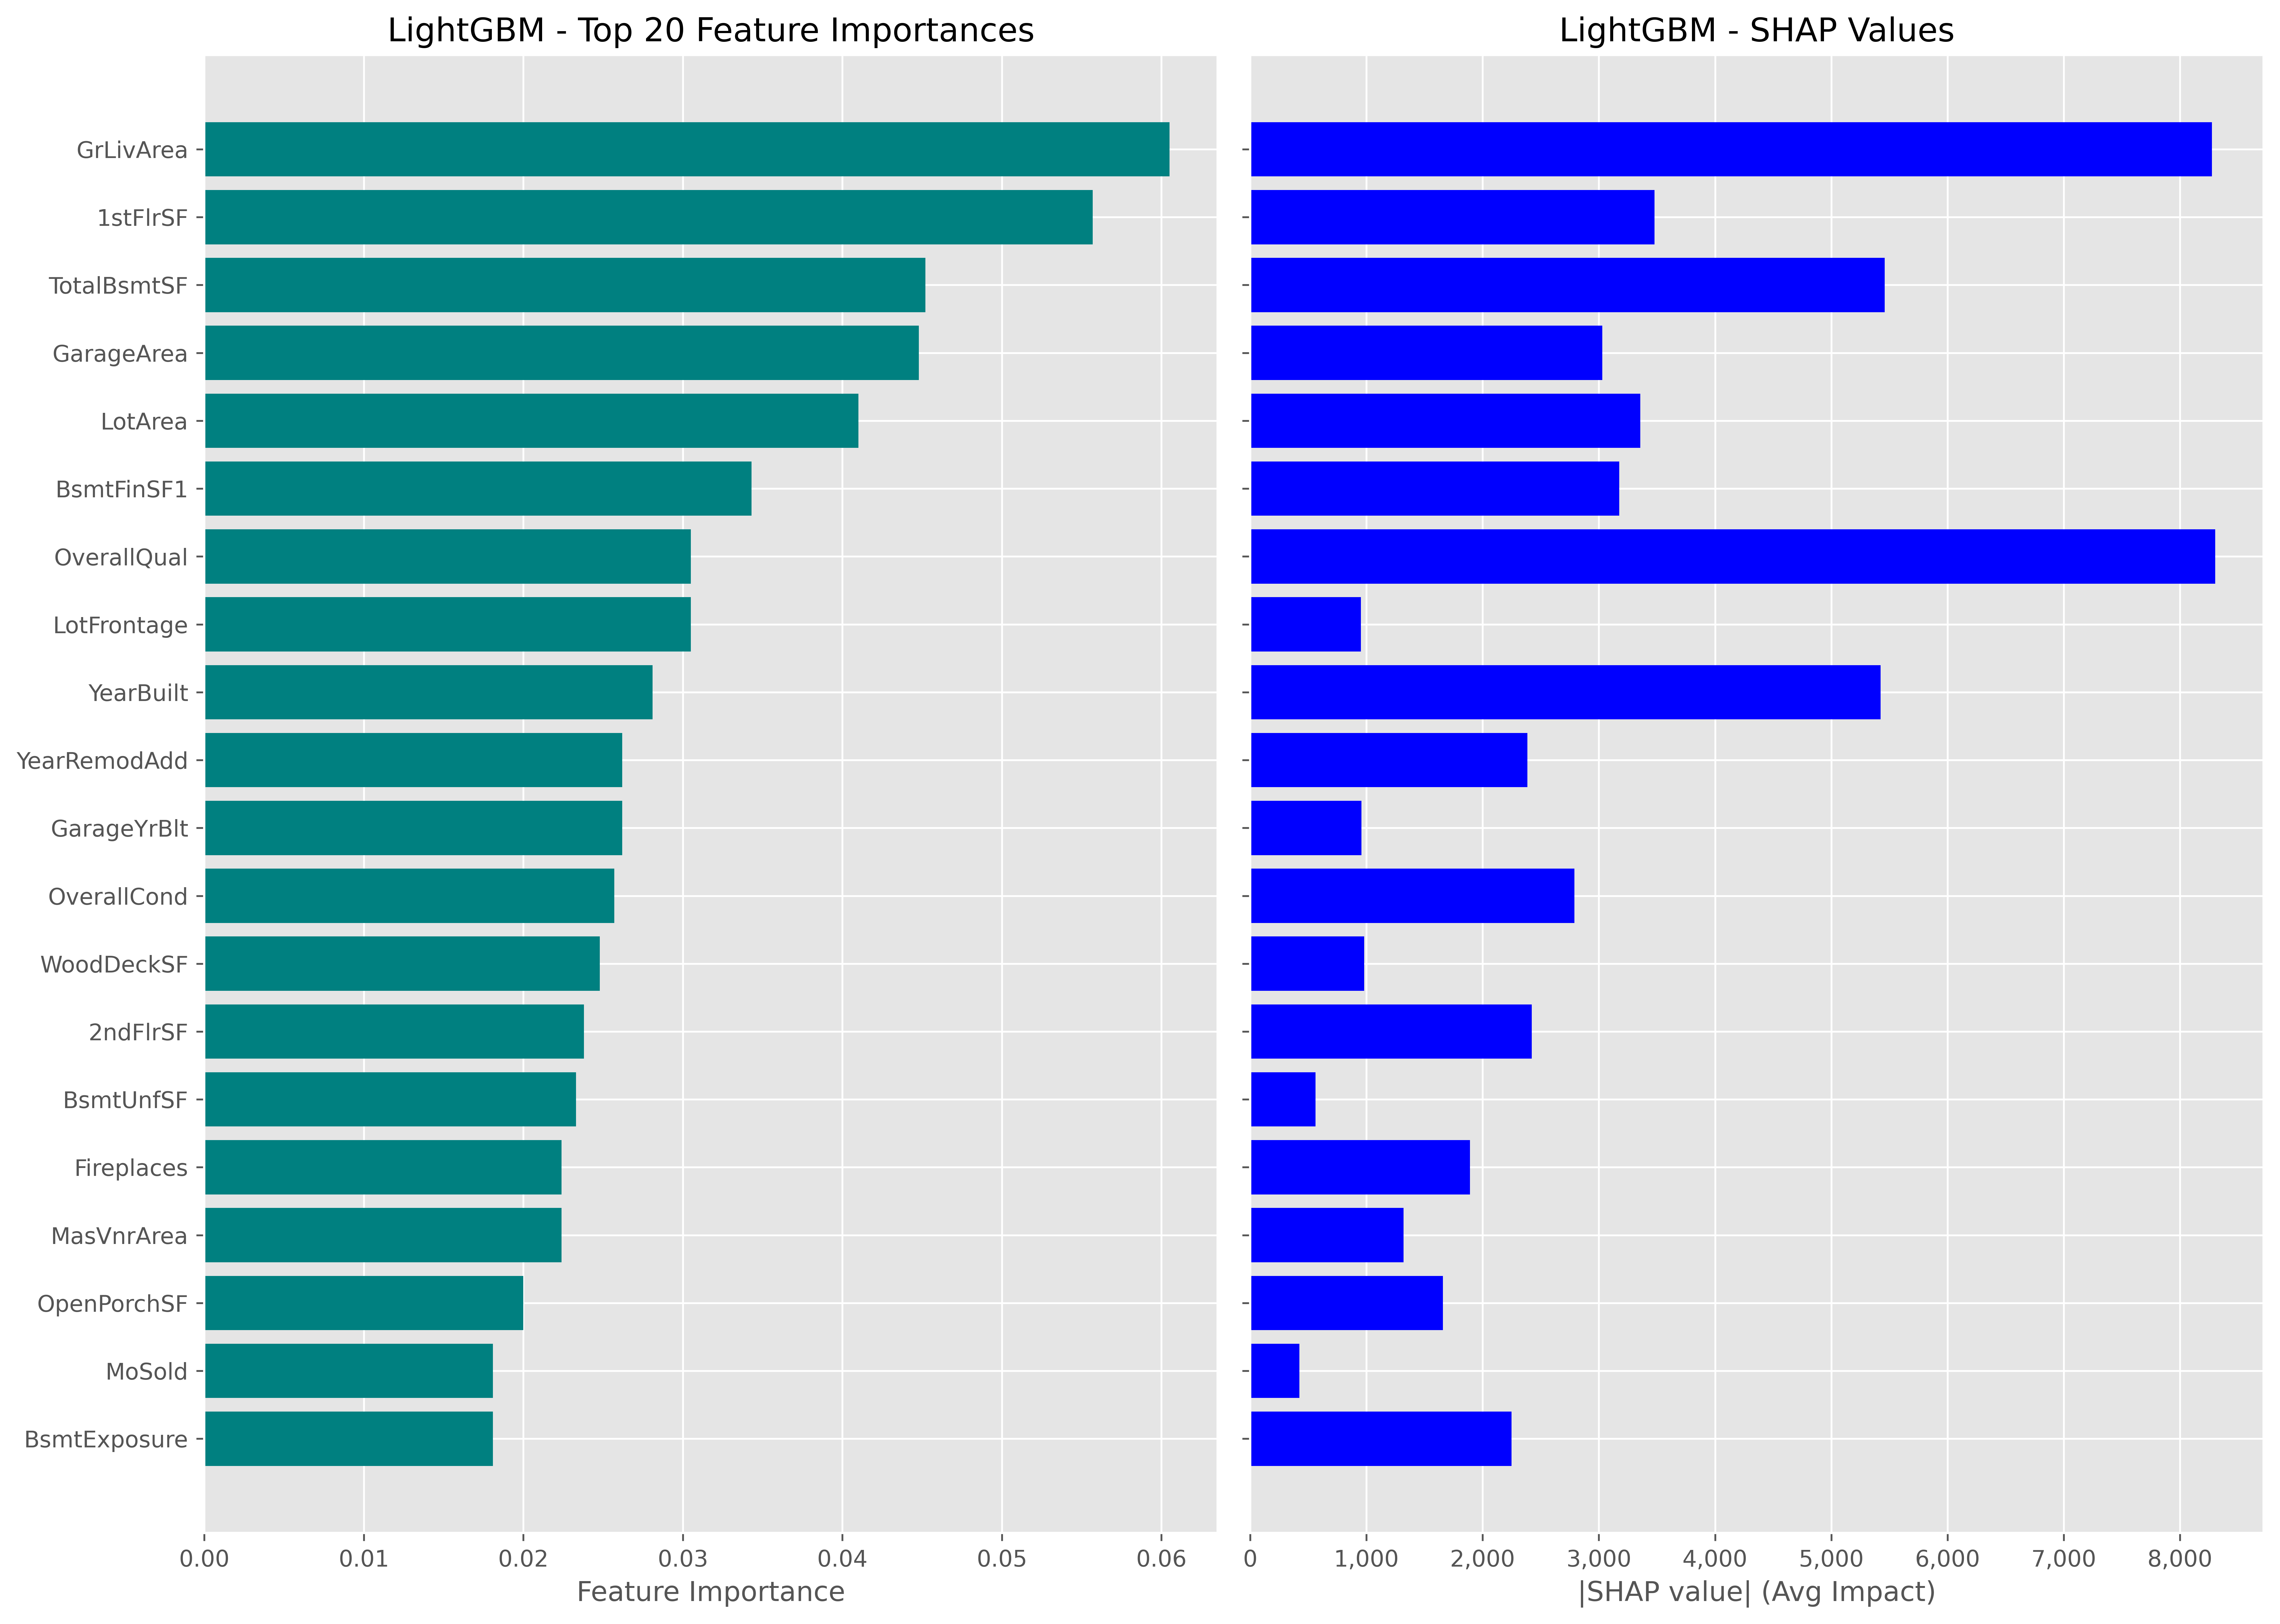

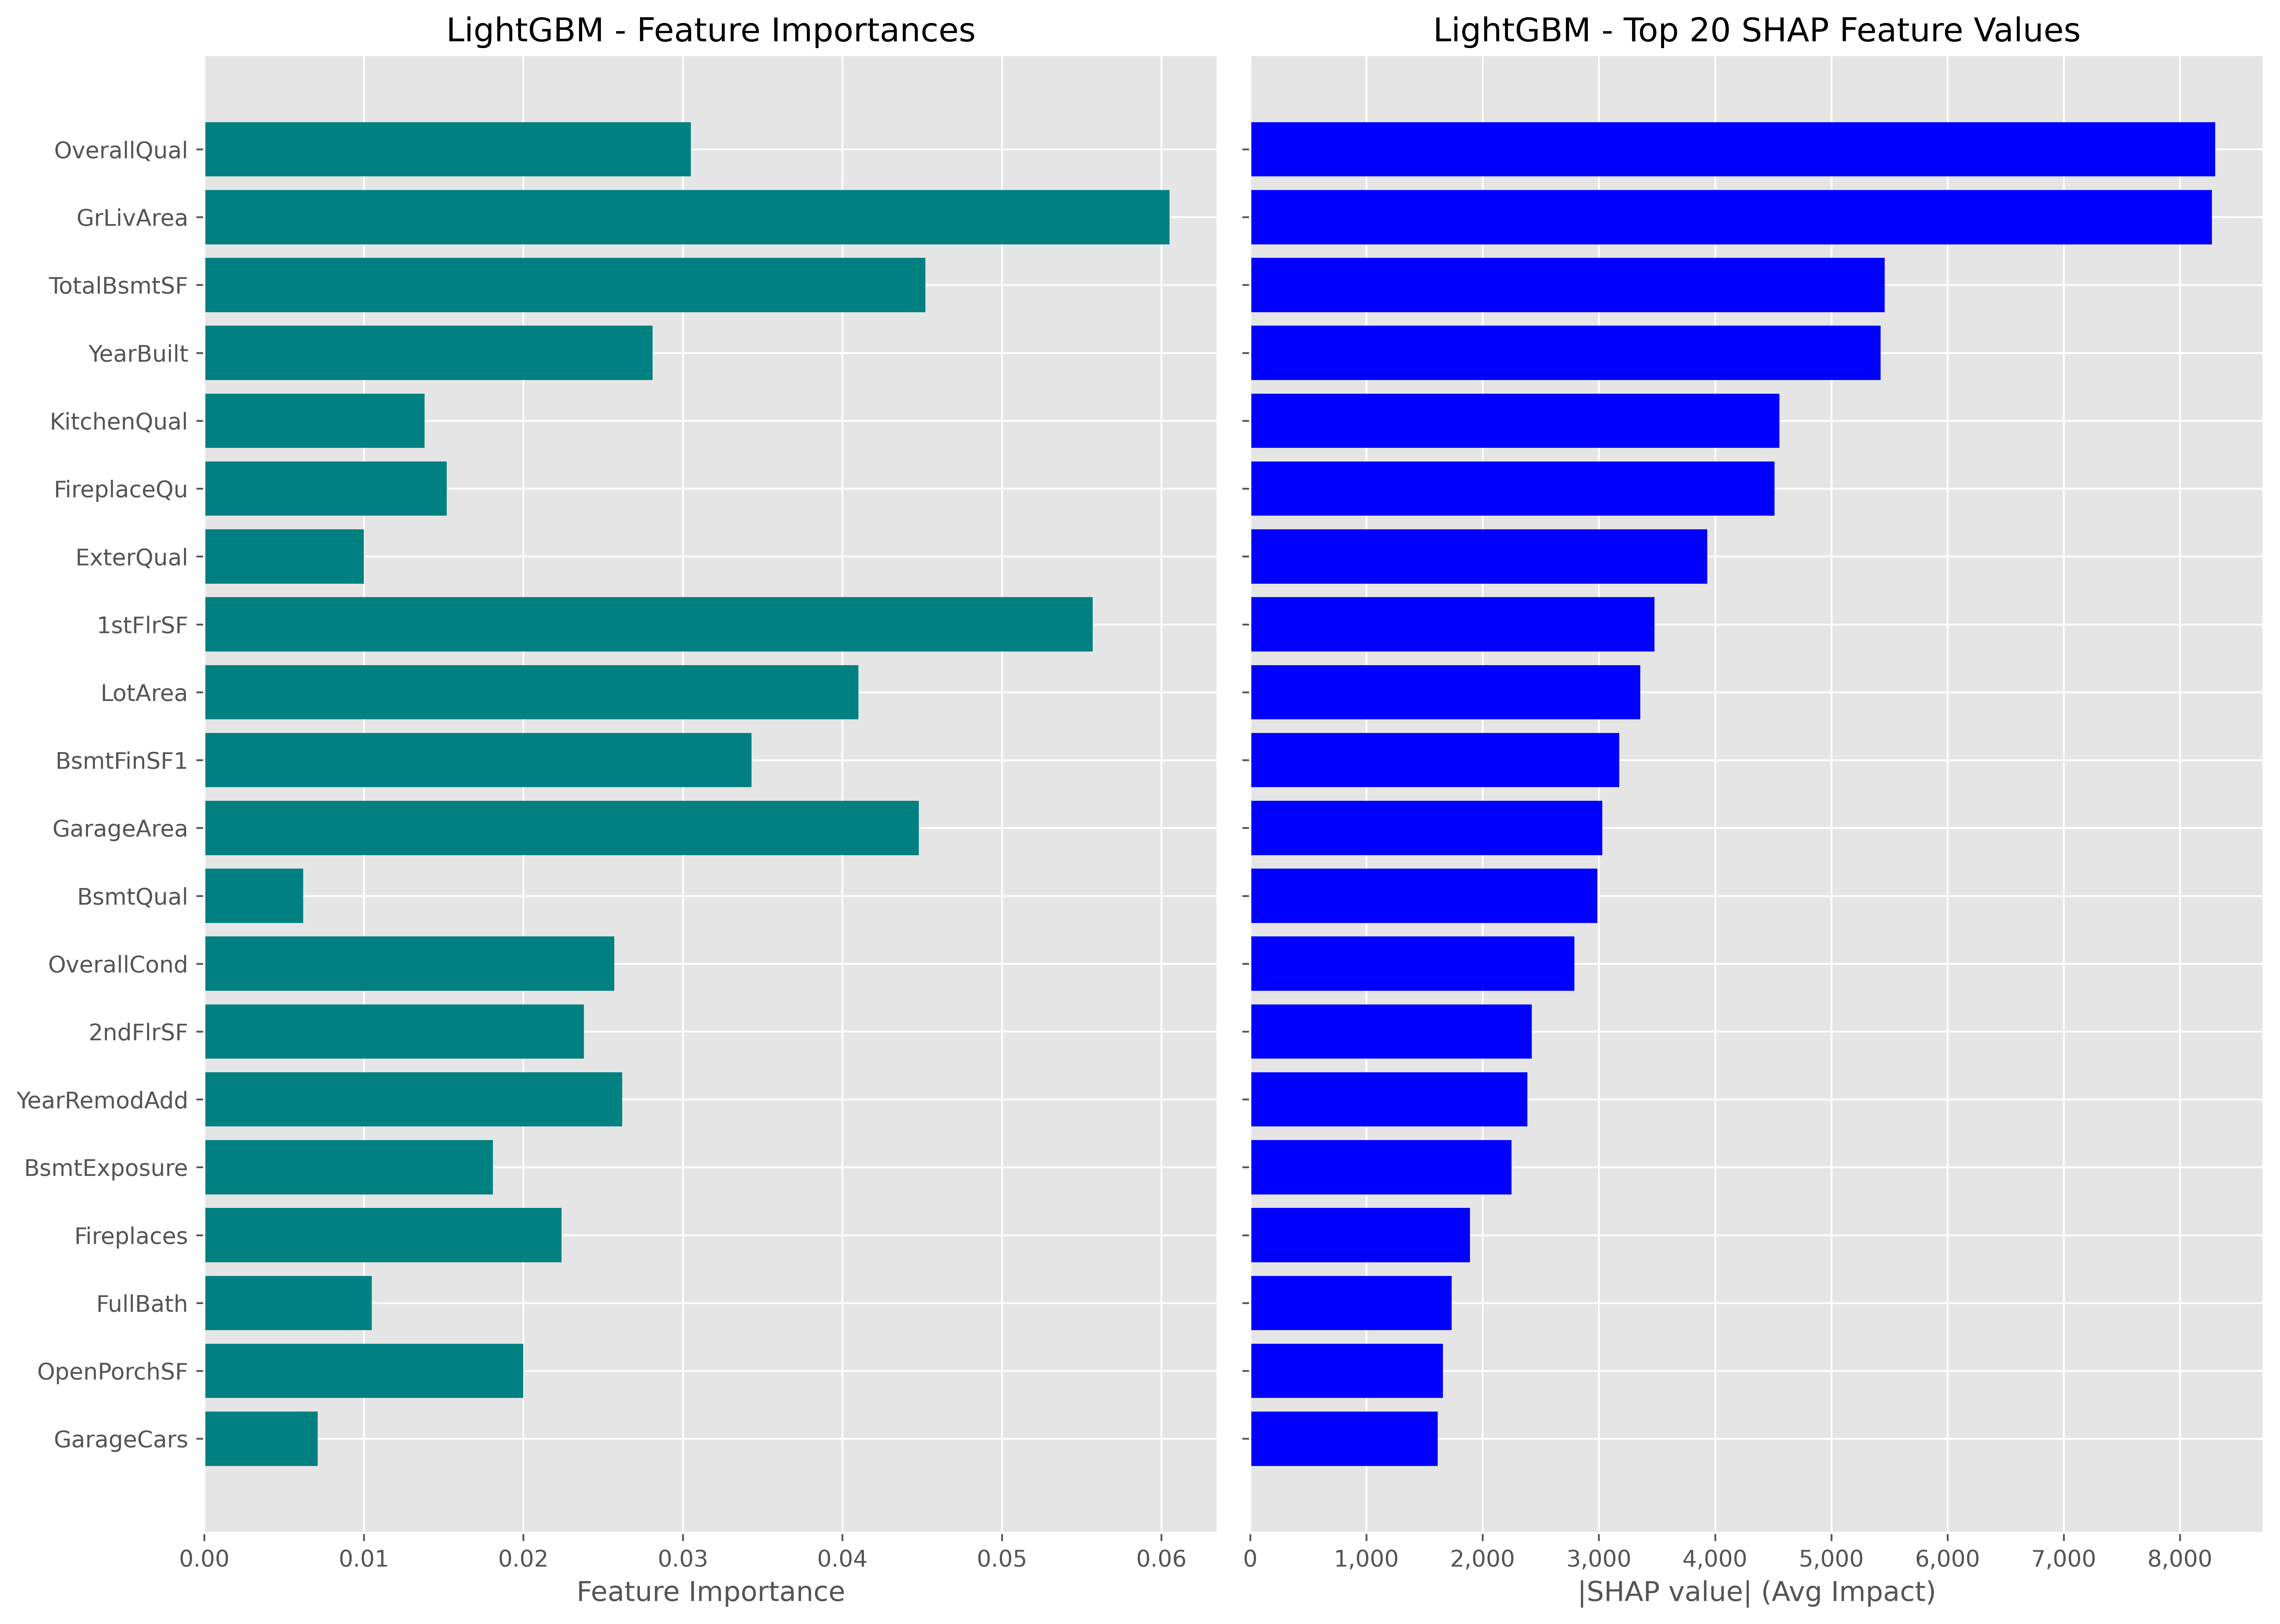


SHAP Beeswarm Plot for LightGBM...


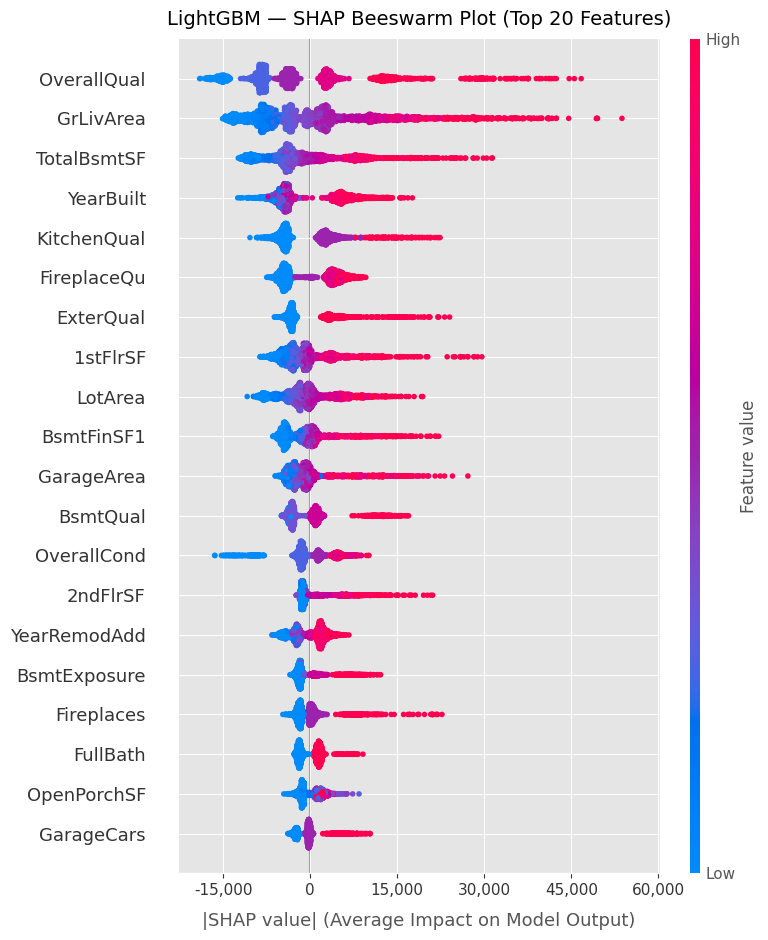

In [34]:
#LightGBM GOSS Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(random_search_lgbm_GOSS, 'LightGBM')

In [9]:
#Base CatBoost Model
cat_boost = CatBoostRegressor(random_state=2, verbose=0, thread_count=-1)
cat_boost_cv_scores = cross_val_score(cat_boost, X, Y, cv=5, scoring='r2')
cat_boost.fit(X, Y)
cat_boost_mean_cv_score = np.mean(cat_boost_cv_scores)
print(f'CatBoost Base Model Mean CV R²: {cat_boost_mean_cv_score}')

#Results Dataframe
cat_boost_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['CatBoost'],
    'Mean_R²': [cat_boost_mean_cv_score],
    **{f'Fold_{i+1}_R²': [cat_boost_cv_scores[i]] for i in range(5)}
})

CatBoost Base Model Mean CV R²: 0.9295837490188994


In [27]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X, Y).mean()))

CatBoost Base Model Score: 0.9295837490188994


In [67]:
#Initial CatBoost RandomizedSearchCV for faster estimates
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')

cat_cv_results_df = pd.DataFrame(random_search_cat.cv_results_)

#Results Dataframe
cat_best_row = cat_cv_results_df.loc[cat_cv_results_df['rank_test_score'] == 1].iloc[0]
cat_fold_scores = [cat_best_row[f'split{i}_test_score'] for i in range(5)]
cat_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['CatBoost'],
    'Mean_R²': [cat_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [cat_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.7, 'min_data_in_leaf': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 0.0, 'iterations': 207, 'depth': 6, 'colsample_bylevel': 0.8}
Best CV Score: 0.9243


 99%|===================| 2549/2579 [01:45<00:01]        

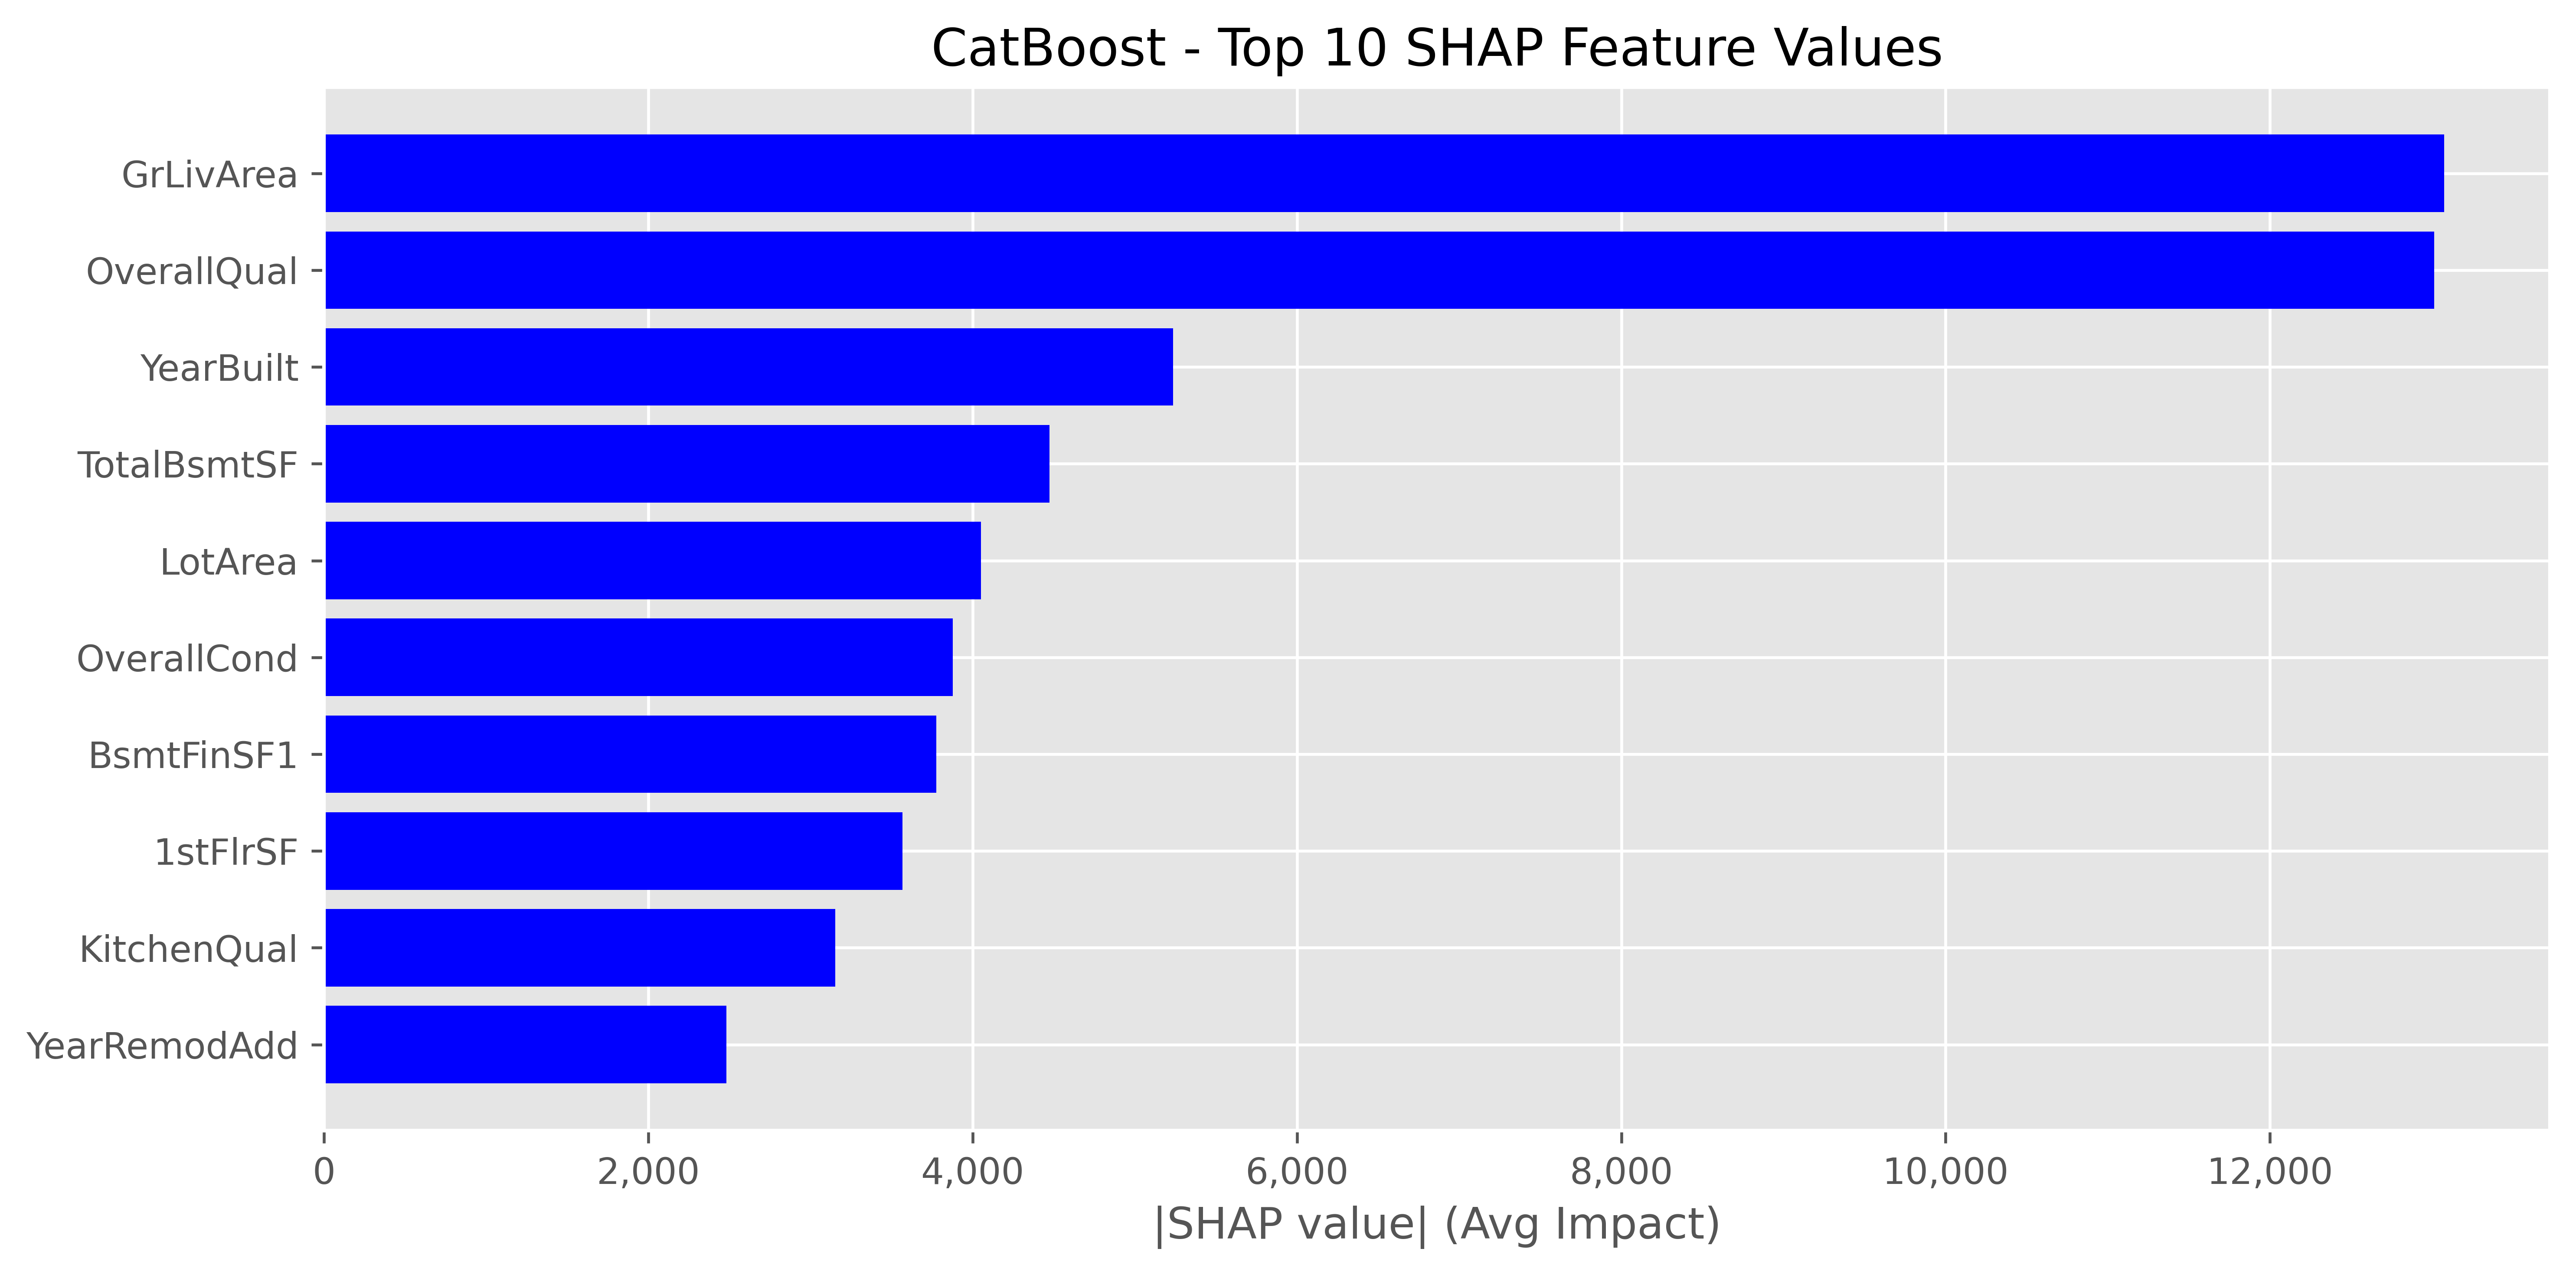


SHAP Beeswarm Plot for CatBoost...


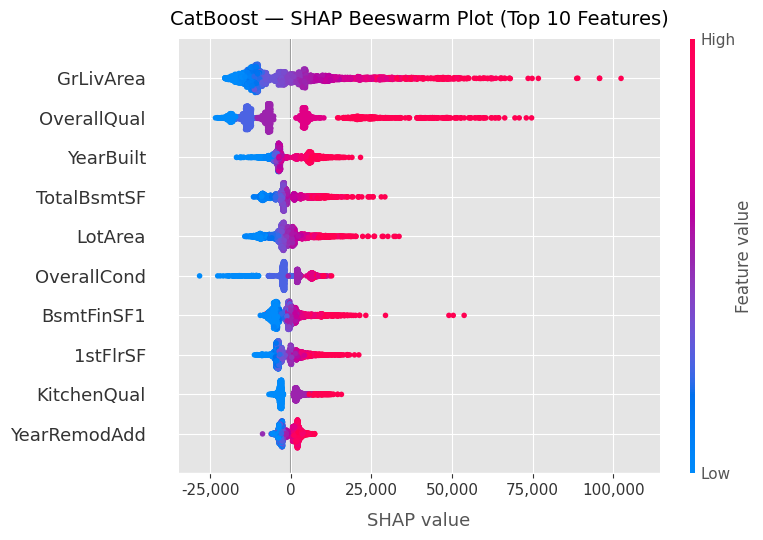

In [16]:
#CatBoost Feature Importances & SHAP values
Plot_SHAP_Values_only(cat_boost, 'CatBoost')

In [64]:
#Base AdaBoost Model
adaBoost = AdaBoostRegressor(estimator=tree_model, random_state=2)
adaBoost_cv_scores = cross_val_score(adaBoost, X, Y, cv=5, scoring='r2')
adaBoost.fit(X, Y)
adaBoost_mean_cv_score = np.mean(adaBoost_cv_scores)
print(f'AdaBoost Base Model Mean CV R²: {adaBoost_mean_cv_score}')

#Results Dataframe
adaBoost_base_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Base'],
    'Model': ['AdaBoost'],
    'Mean_R²': [adaBoost_mean_cv_score],
    **{f'Fold_{i+1}_R²': [adaBoost_cv_scores[i]] for i in range(5)}
})

AdaBoost Base Model Mean CV R²: 0.8990286922227536


In [29]:
print('AdaBoost Base Model Score:', float(cross_val_score(adaBoost, X, Y).mean()))

AdaBoost Base Model Score: 0.8990286922227536


In [66]:
#Initial AdaBoost RandomizedSearchCV for faster estimates
adaBoost_param = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7, 9, 11],
    'n_estimators': range(100, 250),
    'loss': ['linear', 'square', 'exponential']
}
random_search_adaBoost = RandomizedSearchCV(
    estimator=adaBoost,
    param_distributions=adaBoost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_adaBoost.fit(X, Y)
print('Best parameters:', random_search_adaBoost.best_params_)
print(f'Best CV Score: {random_search_adaBoost.best_score_:.4f}')

#Results Dataframe
adaBoost_cv_results_df = pd.DataFrame(random_search_adaBoost.cv_results_)
adaBoost_best_row = adaBoost_cv_results_df.loc[adaBoost_cv_results_df['rank_test_score'] == 1].iloc[0]
adaBoost_fold_scores = [adaBoost_best_row[f'split{i}_test_score'] for i in range(5)]
adaBoost_tuned_results_df = pd.DataFrame({
    'Model_Category': ['Tree_Based'],
    'Model_Scaling': ['None'],
    'Tuning': ['Tuned'],
    'Model': ['AdaBoost'],
    'Mean_R²': [adaBoost_best_row['mean_test_score']],
    **{f'Fold_{i+1}_R²': [adaBoost_fold_scores[i]] for i in range(5)}
})

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'n_estimators': 184, 'loss': 'linear', 'learning_rate': 0.2, 'estimator__max_depth': 7}
Best CV Score: 0.8893


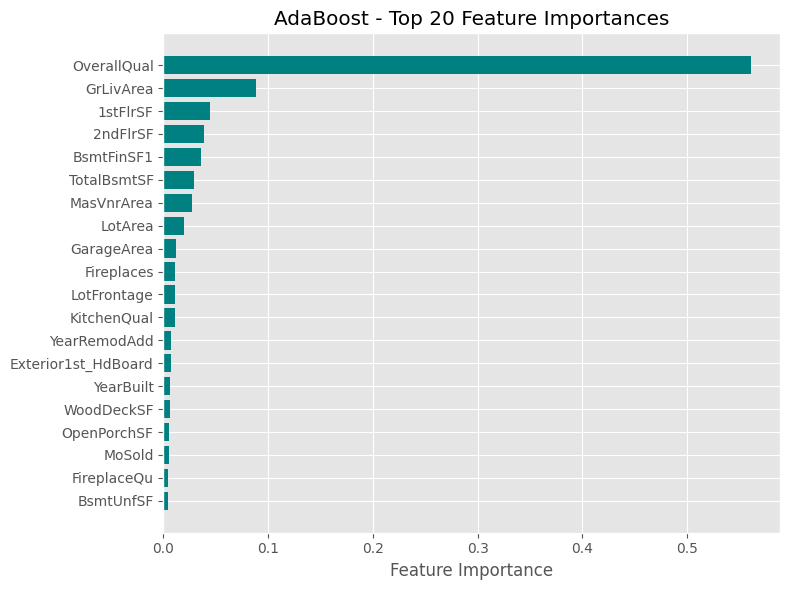

PermutationExplainer explainer: 2580it [16:30,  2.58it/s]                                                              


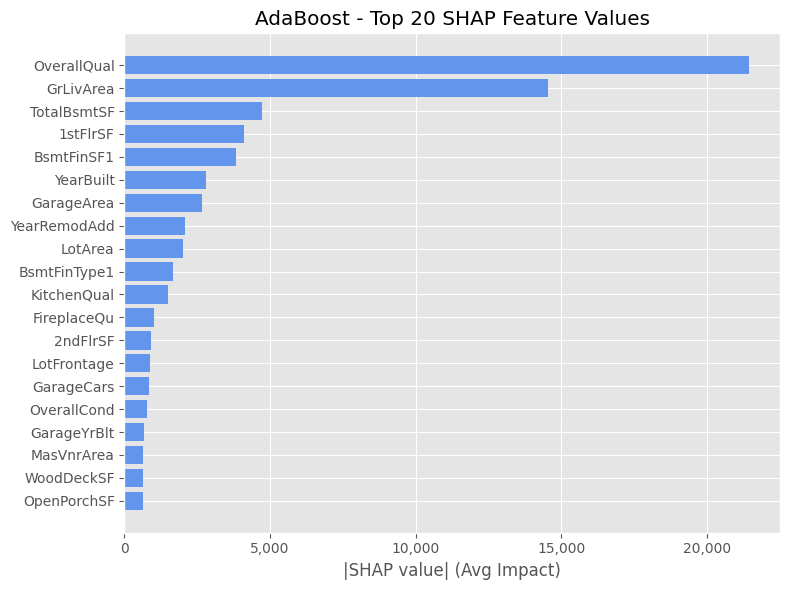

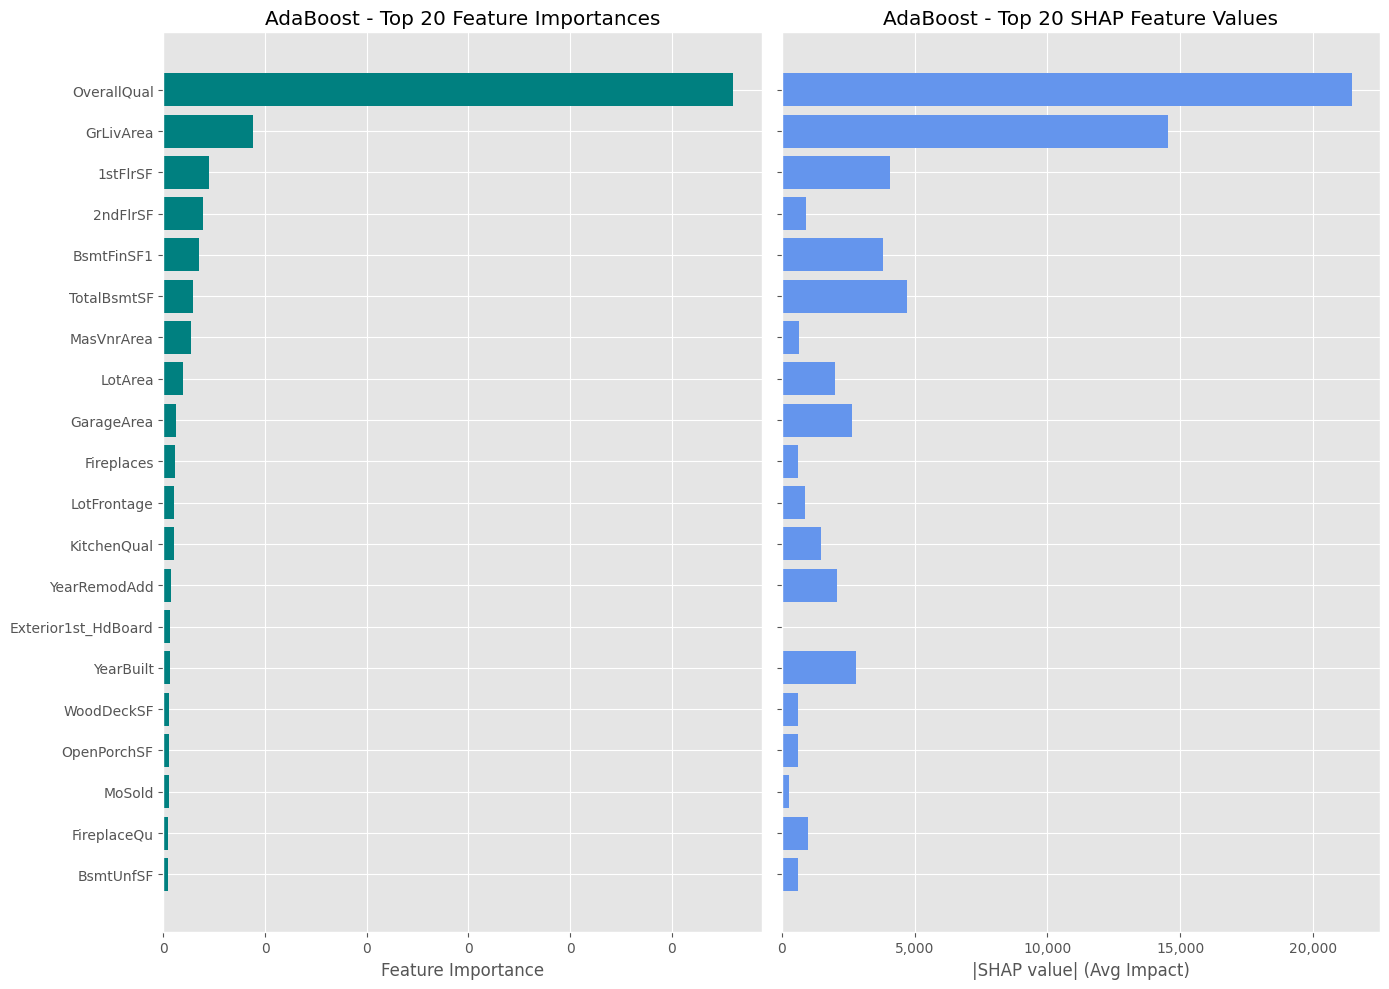

In [117]:
#AdaBoost Feature Importances & SHAP values
Plot_Feature_SHAP_Importances(adaBoost, 'AdaBoost')

In [78]:
#Concatenate all Results
Tree_Results_df = pd.concat(
    [tree_base_results_df,
    tree_tuned_results_df,
    bag_base_results_df,
    bag_tuned_results_df,
    rf_base_results_df,
    rf_tuned_results_df,
    gbm_base_results_df,
    gbm_tuned_results_df,
    hgbm_base_results_df,
    hgbm_tuned_results_df,
    xgbm_base_results_df,
    xgbm_tuned_results_df,
    lgbm_base_results_df,
    lgbm_tuned_results_df,
    lgbm_GOSS_base_results_df,
    lgbm_GOSS_tuned_results_df,
    cat_boost_base_results_df,
    cat_tuned_results_df,
    adaBoost_base_results_df,
    adaBoost_tuned_results_df],
    axis=0,
    ignore_index=True
)

#Better Score column (Base vs Tuned)
Tree_Results_df['Model_Clean'] = Tree_Results_df['Model'].str.replace('_Base|_Tuned', '', regex=True)
Tree_Results_df['Better_Score'] = False
for model_name, group in Tree_Results_df.groupby('Model_Clean'):
    best_idx = group['Mean_R²'].idxmax()
    Tree_Results_df.loc[best_idx, 'Better_Score'] = True
Tree_Results_df.drop(columns=['Model_Clean'], inplace=True)

pd.set_option('display.float_format', lambda x: f'{x:.4f}')
Tree_Results_df

Model_Category Model_Scaling Tuning                 Model  Mean_R²  \
0      Tree_Based          None   Base          DecisionTree   0.7798   
1      Tree_Based          None  Tuned          DecisionTree   0.7916   
2      Tree_Based          None   Base               Bagging   0.8815   
3      Tree_Based          None  Tuned               Bagging   0.8960   
4      Tree_Based          None   Base          RandomForest   0.8952   
5      Tree_Based          None  Tuned          RandomForest   0.8962   
6      Tree_Based          None   Base      GradientBoosting   0.9053   
7      Tree_Based          None  Tuned      GradientBoosting   0.9161   
8      Tree_Based          None   Base  HistGradientBoosting   0.9121   
9      Tree_Based          None  Tuned  HistGradientBoosting   0.9221   
10     Tree_Based          None   Base               XGBoost   0.8996   
11     Tree_Based          None  Tuned               XGBoost   0.9226   
12     Tree_Based          None   Base              LightGBM   0.9115   
13     Tree_Based          None  Tuned              LightGBM   0.9211   
14     Tree_Based          None   Base         LightGBM_GOSS   0.9109   
15     Tree_Based          None  Tuned         LightGBM_GOSS   0.9185   
16     Tree_Based          None   Base              CatBoost   0.9296   
17     Tree_Based          None  Tuned              CatBoost   0.9243   
18     Tree_Based          None   Base              AdaBoost   0.8990   
19     Tree_Based          None  Tuned              AdaBoost   0.8893   

    Fold_1_R²  Fold_2_R²  Fold_3_R²  Fold_4_R²  Fold_5_R²  Better_Score  
0      0.7605     0.8198     0.7639     0.7999     0.7548         False  
1      0.7554     0.8277     0.7637     0.7956     0.8157          True  
2      0.8162     0.8853     0.8979     0.8958     0.9124         False  
3      0.8419     0.8995     0.9089     0.9132     0.9163          True  
4      0.8411     0.8966     0.9076     0.9152     0.9154         False  
5      0.8739     0.8891     0.9022     0.9133     0.9023          True  
6      0.8307     0.9143     0.9224     0.9314     0.9278         False  
7      0.8820     0.9160     0.9260     0.9311     0.9257          True  
8      0.8535     0.9139     0.9300     0.9330     0.9302         False  
9      0.8663     0.9246     0.9374     0.9417     0.9402          True  
10     0.8464     0.8975     0.9161     0.9120     0.9262         False  
11     0.8698     0.9243     0.9387     0.9359     0.9442          True  
12     0.8590     0.9096     0.9266     0.9340     0.9282         False  
13     0.8716     0.9191     0.9393     0.9379     0.9375          True  
14     0.8636     0.9089     0.9252     0.9264     0.9306         False  
15     0.8691     0.9150     0.9335     0.9379     0.9368          True  
16     0.8842     0.9286     0.9452     0.9432     0.9467          True  
17     0.8722     0.9248     0.9402     0.9404     0.9440         False  
18     0.8515     0.9079     0.9034     0.9166     0.9157          True  
19     0.8394     0.8952     0.8939     0.9090     0.9090         False

In [79]:
#Export Results
Tree_Results_df.to_csv('Tree_Results.csv', index=False)